In [1]:
import sys
sys.path.append("./modules")

from modules.data_utils import load_data, extract_xy_from_loader, sample_batch, PCAEncoder, data_scaler, dataset_dataloaders
from modules.plot_utils import visualize_umap, show_images_batch, data_variance_plot, feature_heatmap, plot_metric_with_std, plot_confusion_matrix, plot_auroc, plot_prec, plot_reconstructed_heatmaps_with_predictions, plot_noise_comparison, reliability_diagram_multi
from modules.model_utils import cv_qcnn, QuantumLinear, gradcam_model, ClassicalModel, dv_qcnn, DVQuantumLinear,get_cv_qcnn_qnode, get_dv_qcnn_qnode, compute_ece, brier_score
from modules.training_validating import run_kfold_training, evaluate_v2, noise_robustness_validation

import torch
from torch.utils.data import DataLoader, Subset
from torch.utils.data import TensorDataset
from pennylane import draw_mpl
import torch.optim as optim
import torch.nn as nn

import pickle
import json
import umap
import joblib


import matplotlib.pyplot as plt

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_flag = "organamnist"
train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(data_flag, batch_size=32, train_fraction=0.3)
# train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(data_flag, batch_size=32, train_fraction=0.1)

In [3]:
# encoder = PCAEncoder(n_components=4)
# encoder.fit(train_raw_loader)

# loading once trained
encoder = PCAEncoder(n_components=4)
# encoder.pca = joblib.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_organ.pkl")
encoder.pca = joblib.load("/home/dalopezm/gaussian-qnns/model_checkpoints/pca_encoder_organ.pkl")
encoder.fitted = True


x_train_encoded, y_train_tensor = encoder.transform(train_raw_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_raw_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_raw_loader)

In [4]:
# joblib.dump(encoder.pca, "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_organ.pkl")

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


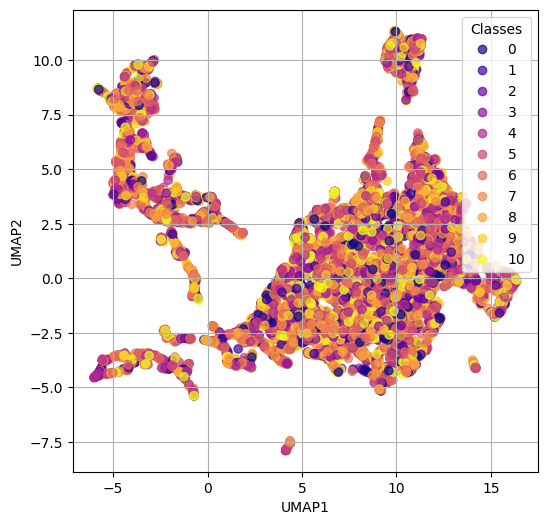

In [5]:
y_train = torch.cat([y for _, y in train_raw_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


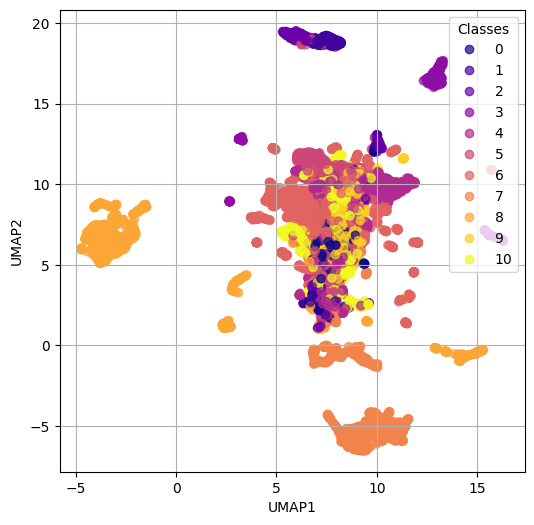

In [6]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_raw_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

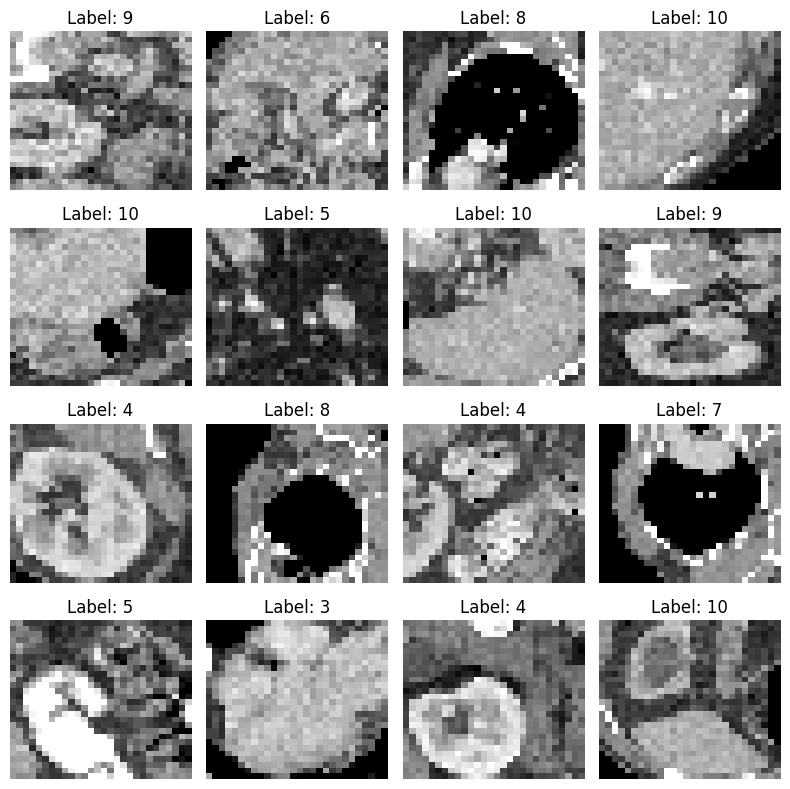

In [7]:
x_batch, y_batch = sample_batch(train_raw_loader, n_samples=16)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_94793/214262766.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


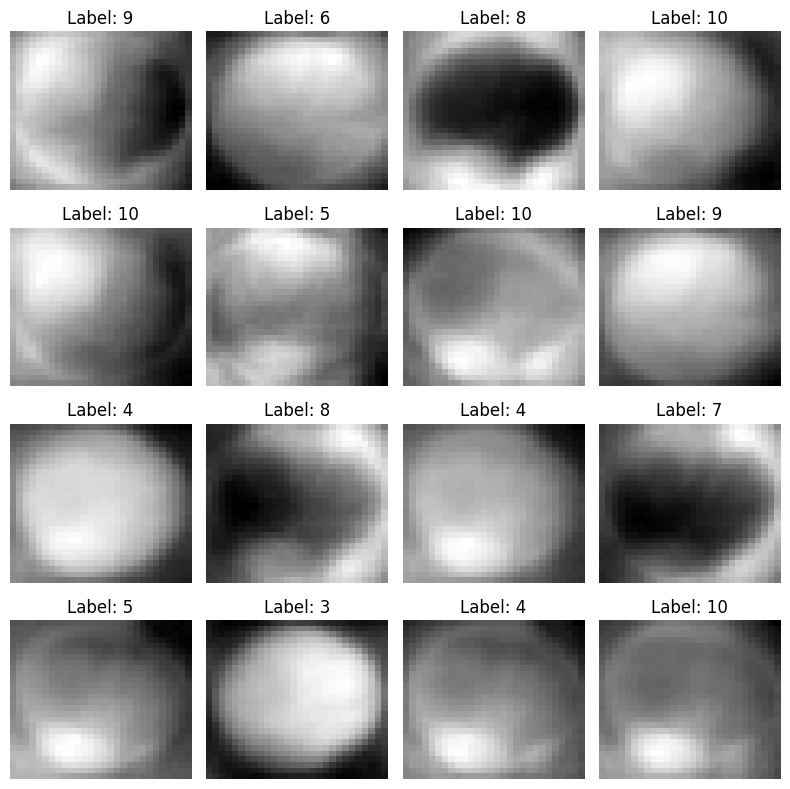

In [8]:
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=16, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

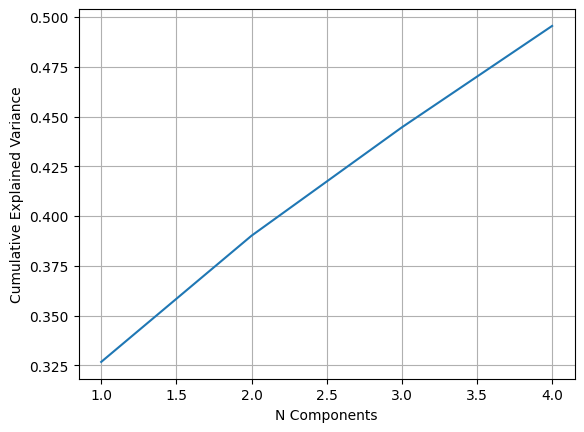

In [9]:
data_variance_plot(encoder)

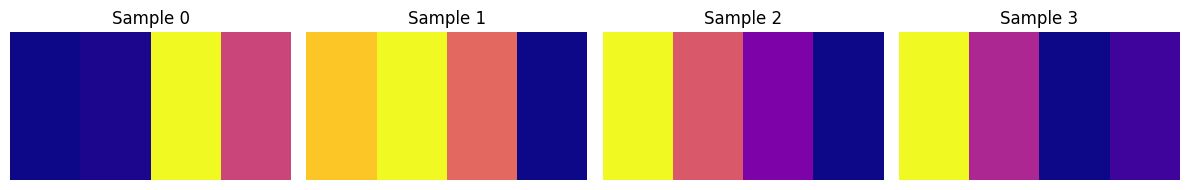

In [10]:
feature_heatmap(x_train_encoded)

## CONTINUOUS VARIABLE MODEL

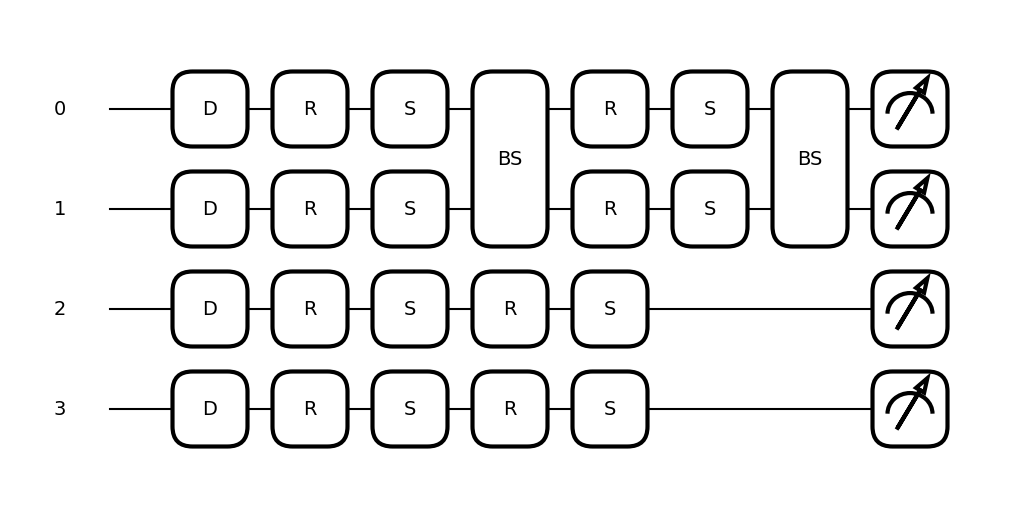

In [11]:
n_qumodes = 4
dummy_inputs = torch.zeros(n_qumodes)
dummy_weights = torch.zeros((2, n_qumodes, 4))
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights, n_qumodes)

In [12]:
save_database_name = "organ"

#run once to train
# x_train_tensor, x_val_tensor, x_test_tensor = data_scaler(x_train_encoded, x_val_encoded, x_test_encoded, save_database_name=save_database_name)

In [13]:
#load once trained
# scaler = joblib.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_scaler_{save_database_name}.pkl")
scaler = joblib.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/pca_scaler_{save_database_name}.pkl")

x_train_scaled = scaler.transform(x_train_encoded)
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

x_val_scaled = scaler.transform(x_val_encoded)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)

x_test_scaled = scaler.transform(x_test_encoded)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [14]:
train_dataset, train_loader = dataset_dataloaders(x_train_tensor, y_train_tensor.squeeze())
val_dataset, val_loader = dataset_dataloaders(x_val_tensor, y_val_tensor)
test_dataset, test_loader = dataset_dataloaders(x_test_tensor, y_test_tensor)

In [15]:
x_train_pca, y_train_pca = extract_xy_from_loader(train_loader)

In [16]:
x_train_pca_sample, y_train_pca_sample = train_dataset[0]

In [17]:
print(y_train_pca_sample)
print(y_train_pca_sample.dtype)

tensor(9)
torch.int64


In [18]:
print(y_train_pca.shape, y_train_pca)
print(y_train_pca.dtype)

torch.Size([10368]) tensor([6, 2, 7,  ..., 9, 7, 6])
torch.int64


In [19]:
# epochs = 3
# epochs = 30
epochs = 50
device = "cpu"
# cv_model = QuantumLinear(n_qumodes=4, n_classes=11).to(device)
n_classes=11
cv_model = QuantumLinear(n_qumodes=4, n_classes=n_classes).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [20]:
from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumLinear                            --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       55
Total params: 87
Trainable params: 87
Non-trainable params: 0

In [21]:
model_name = "cv_organ"

In [19]:
run_kfold_training(QuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3
 
Epoch 1/50 (fold 1)


Training | Fold 1 | Epoch 1:   4%| | 9/216 [00:19<07:19,  2.12s/it, loss=664.723


KeyboardInterrupt: 

In [22]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

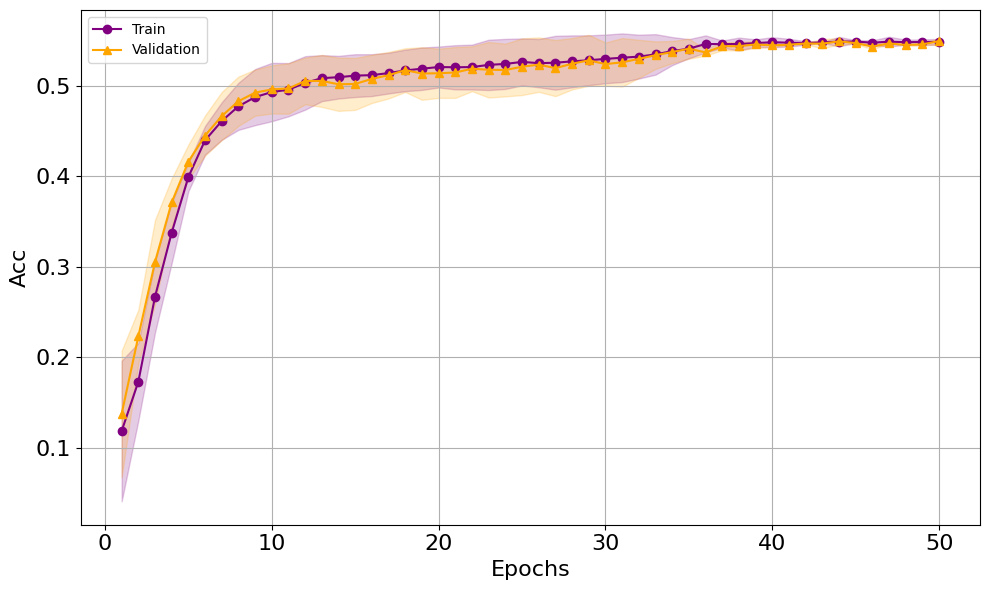

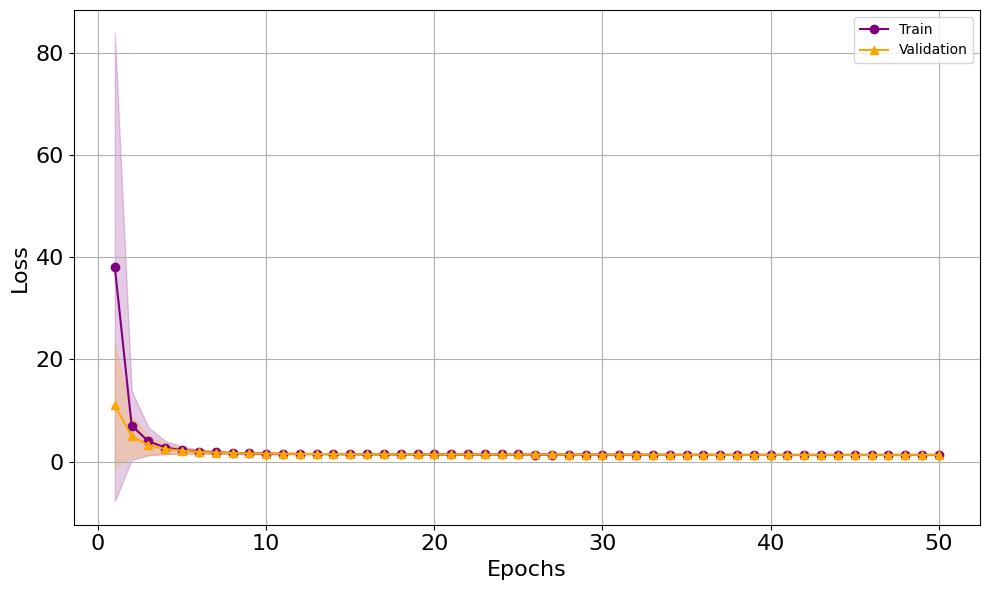

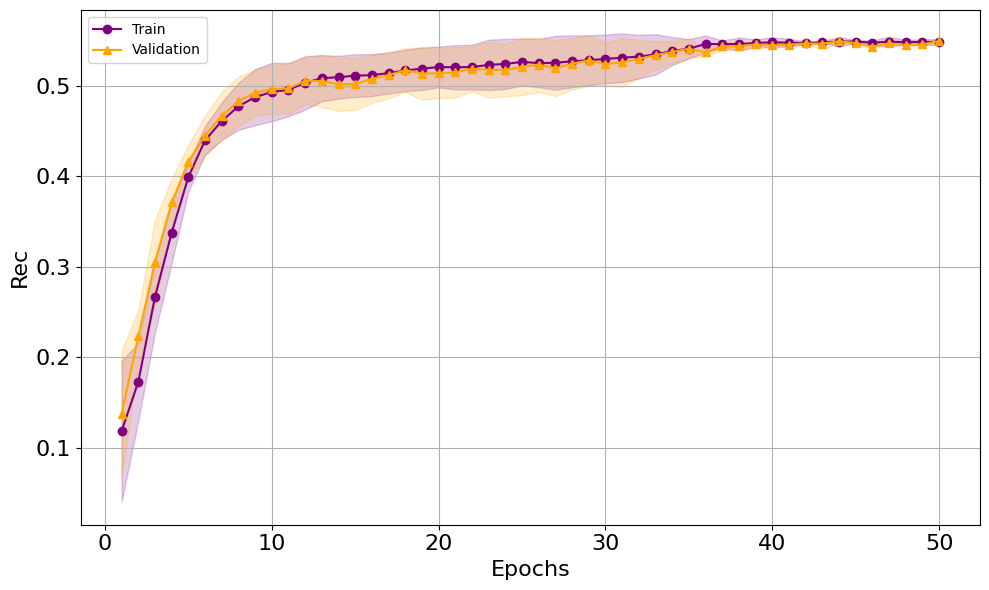

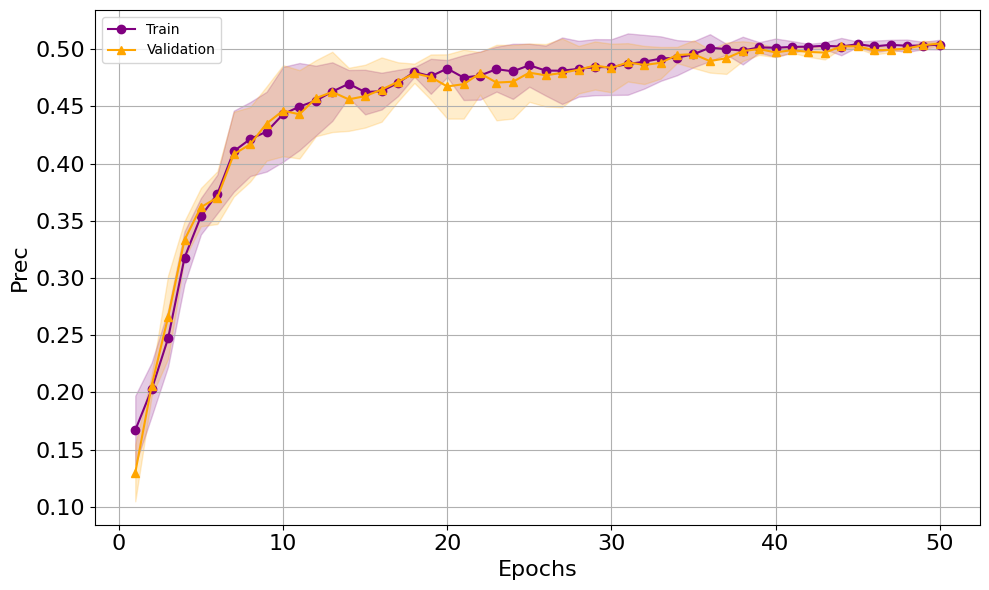

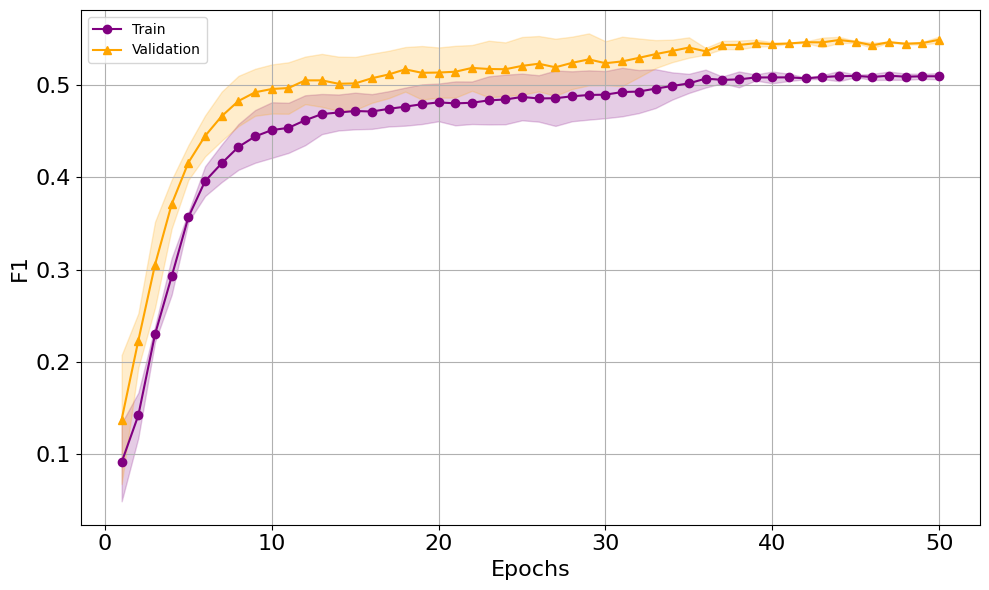

In [21]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [23]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 1 with val_f1 = 0.5535


In [24]:
device = "cpu"
test_cv_model = QuantumLinear(n_qumodes=4, n_classes=11).to(device)

# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

# test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_cv_model, test_loader, optimizer, criterion, device)
test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, cv_test_probs, cv_test_labels = evaluate_v2(test_cv_model, test_loader, optimizer, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 556/556 [00:59<00:00,  9.36it/s, loss=1.6347, acc


Test loss: 1.6347 | Test acc: 0.4515 | Test rec: 0.4515 | Test prec: 0.4191 | Test f1: 0.4515


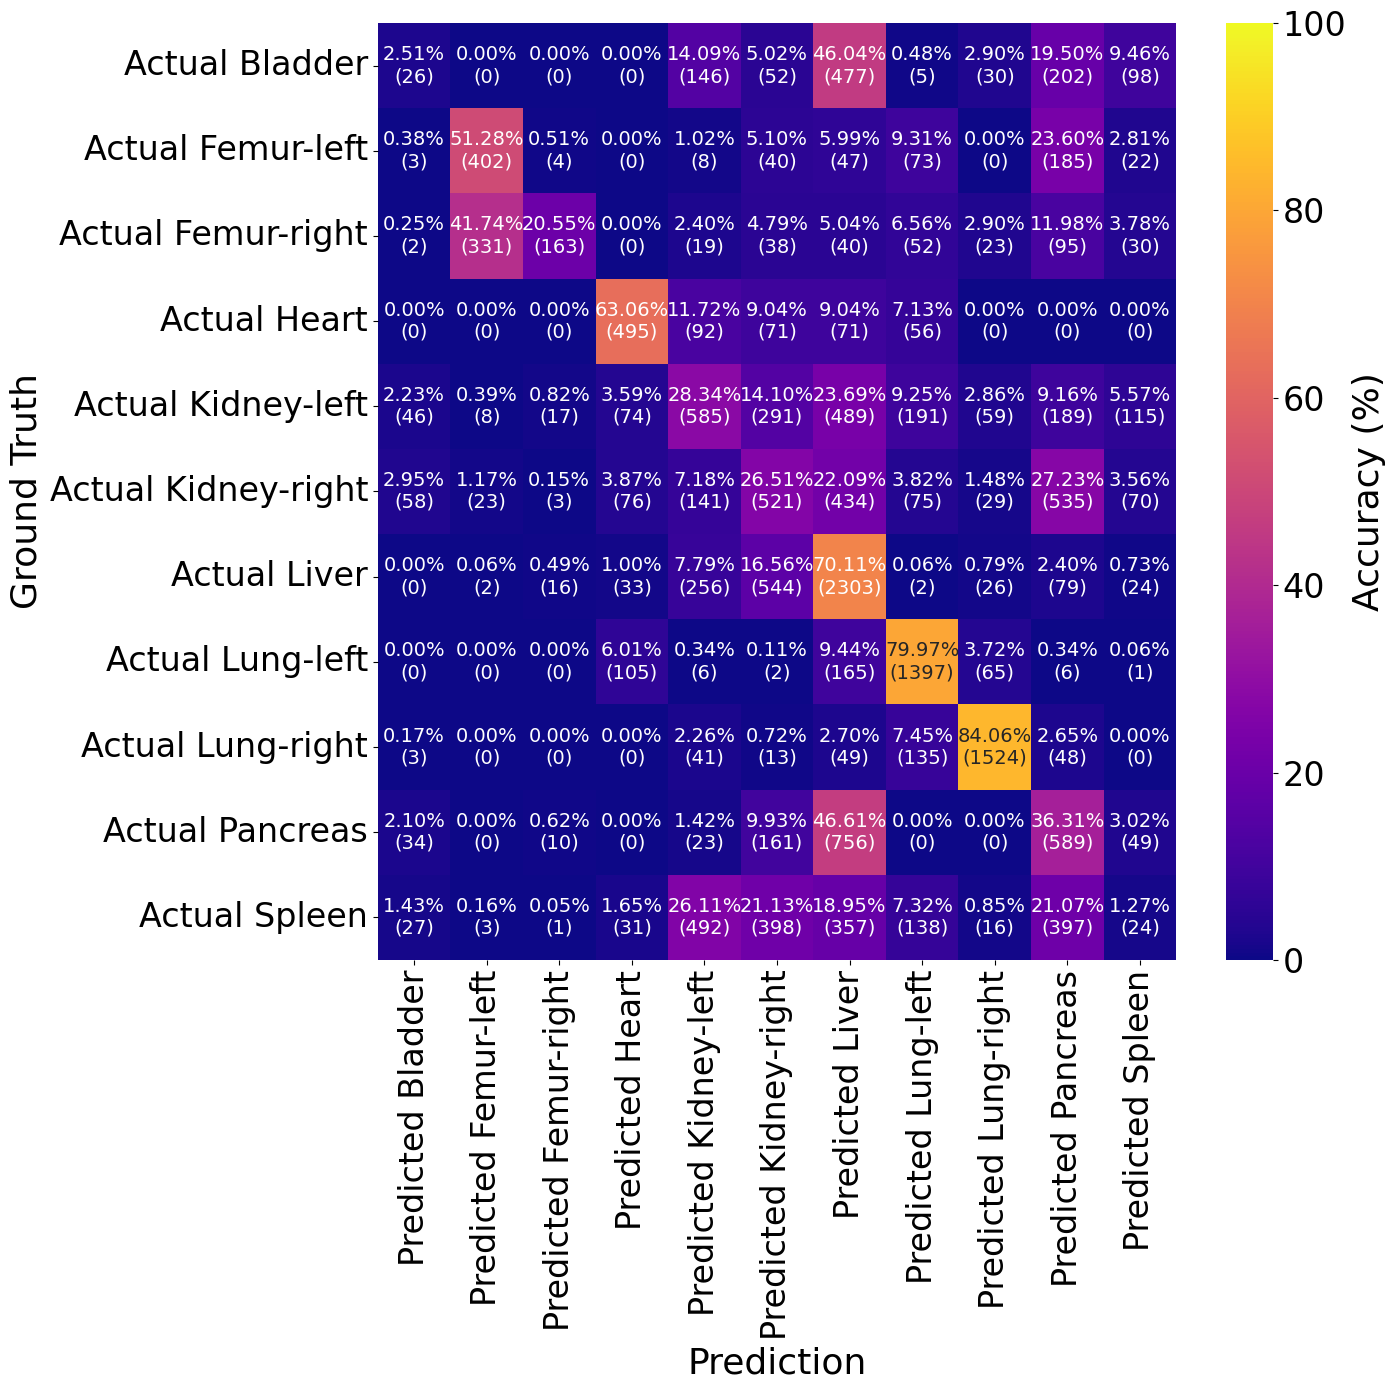

In [44]:
# label_names = ["Normal", "Pneumonia"]
label_names = [
    "Bladder",
    "Femur-left",
    "Femur-right",
    "Heart",
    "Kidney-left",
    "Kidney-right",
    "Liver",
    "Lung-left",
    "Lung-right",
    "Pancreas",
    "Spleen",
]

plot_confusion_matrix(cv_test_labels, test_preds, label_names, model_name, binary=False)

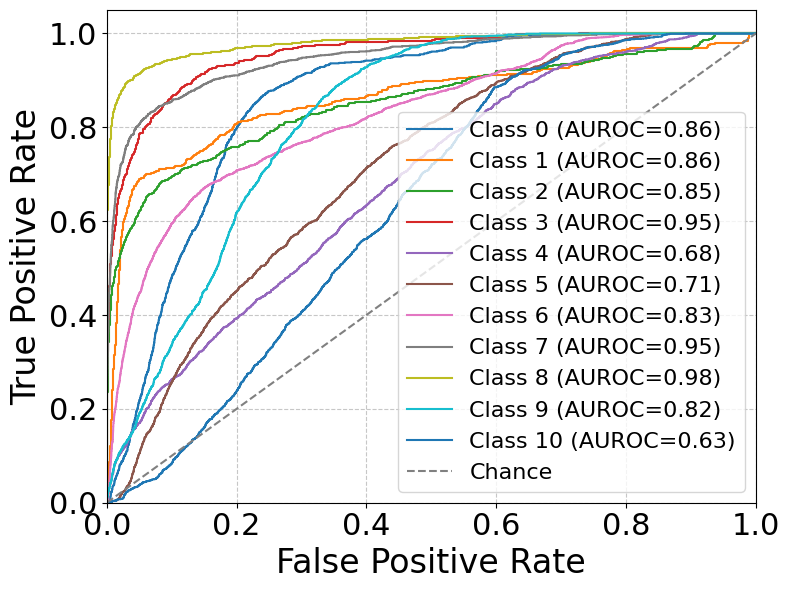

In [45]:
plot_auroc(cv_test_labels, cv_test_probs, model_name, binary=False)

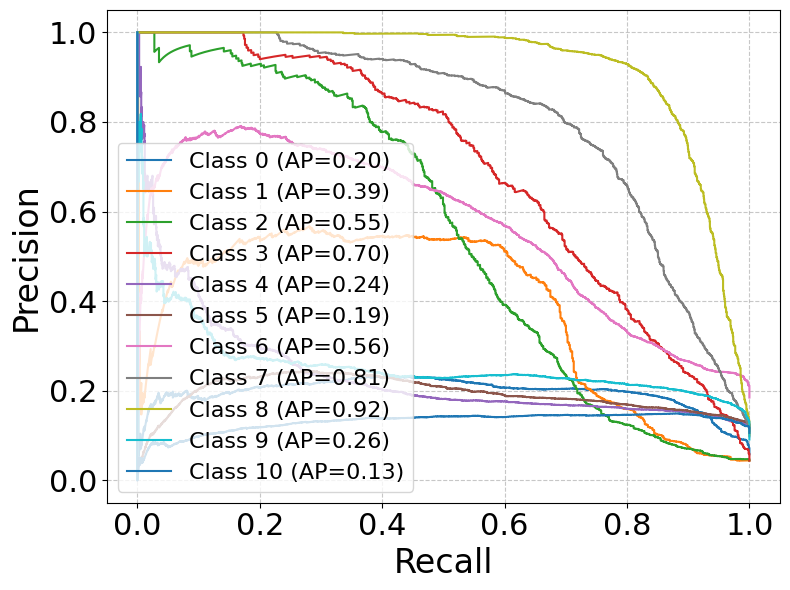

In [46]:
plot_prec(cv_test_labels, cv_test_probs, model_name, binary=False)

In [33]:
cam, outputs, predictions = gradcam_model(test_cv_model, x_test_tensor[0:16], quantum=True)
print(cam.shape)

torch.Size([16, 4])


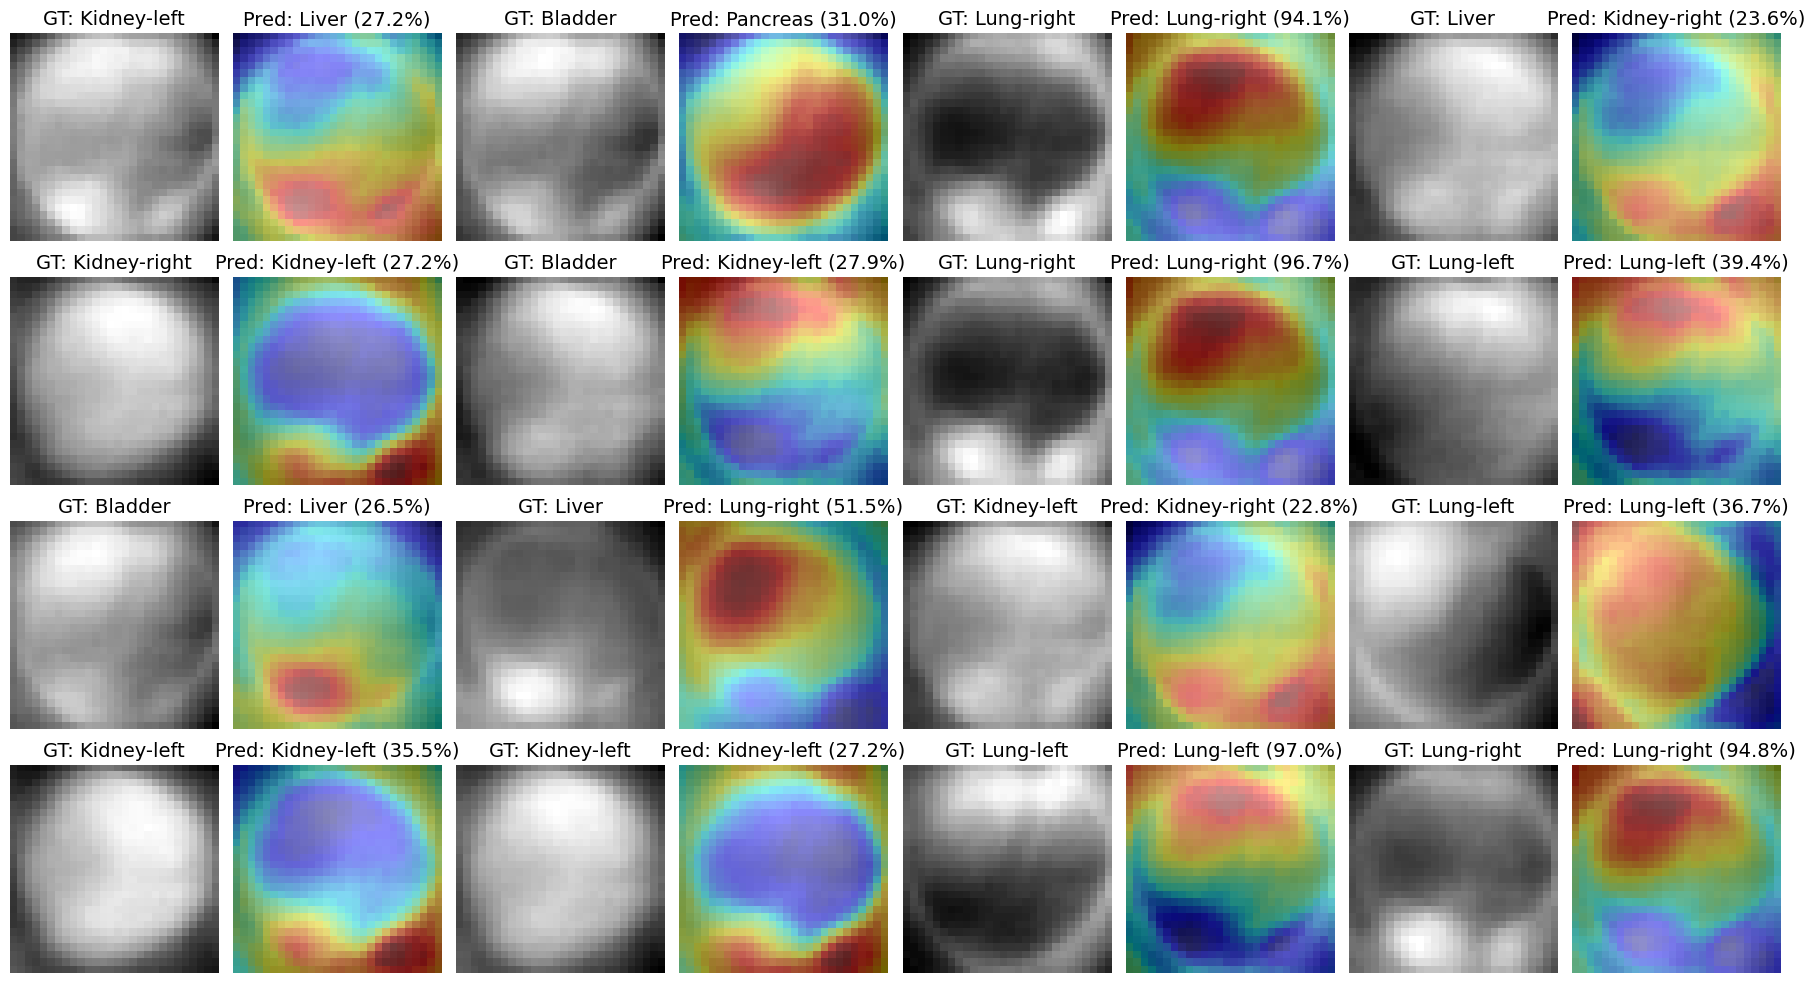

In [34]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## DISCRETE MODEL

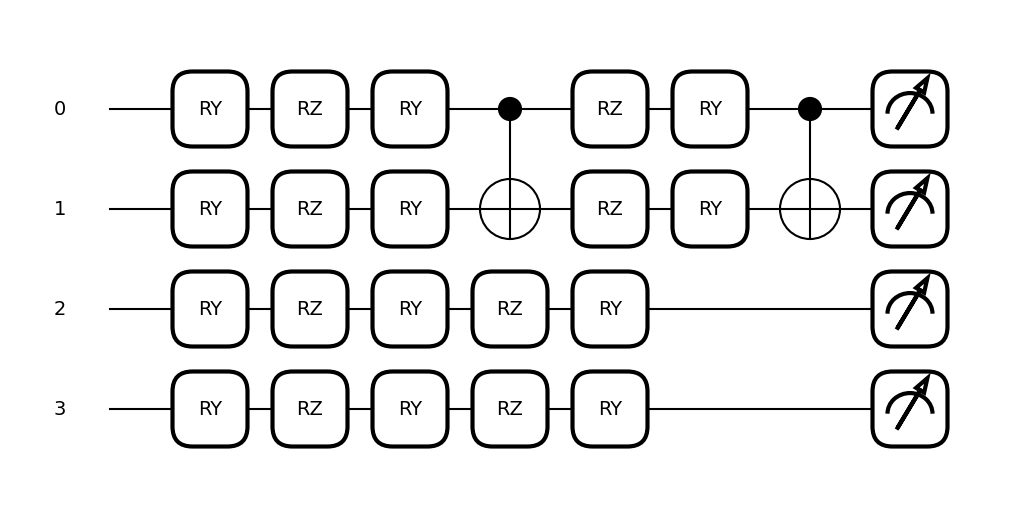

In [25]:
n_qubits = 4
dummy_inputs = torch.zeros(n_qubits)
dummy_weights = torch.zeros((2, n_qubits, 4))

fig, ax = draw_mpl(dv_qcnn)(dummy_inputs, dummy_weights, n_qubits)

In [26]:
model_name = "dv_organ"

In [49]:
run_kfold_training(DVQuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3
 
Epoch 1/50 (fold 1)


Training | Fold 1 | Epoch 1:   4%| | 8/216 [00:04<01:52,  1.85it/s, loss=2.6798,


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_73684/2370760418.py", line 1, in <module>
    run_kfold_training(DVQuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)
  File "/home/dalopezm/quantum-studies/quantum-cv/modules/training_validating.py", line 163, in run_kfold_training
    train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model, train_loader, optimizer, criterion, device, epoch=epoch+1, fold=fold+1)
  File "/home/dalopezm/quantum-studies/quantum-cv/modules/training_validating.py", line 31, in train_v2
    outputs = model(x_batch)
  File "/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    ret

In [27]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}
# model_name = "organ-dv-linear"


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

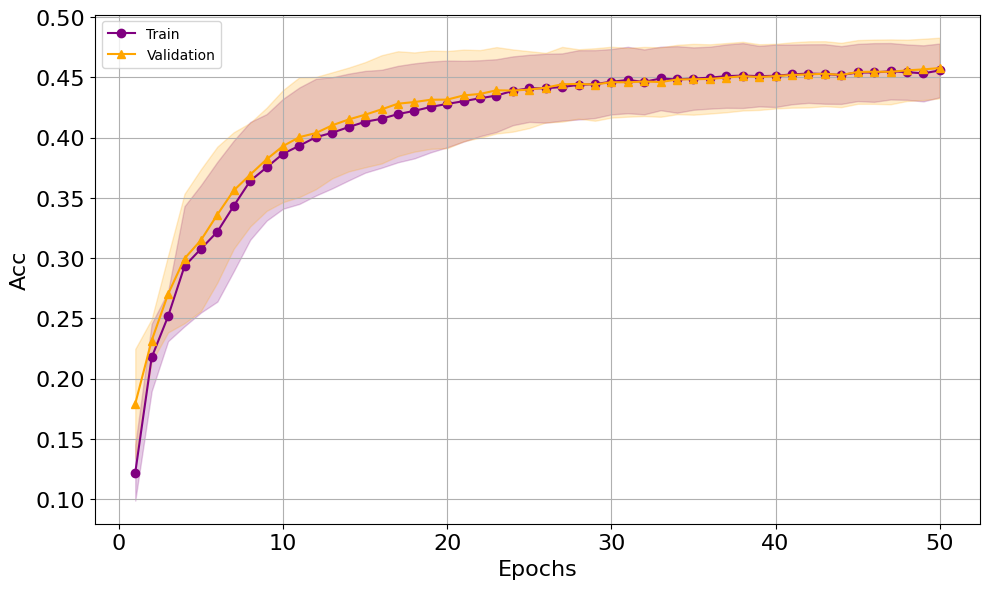

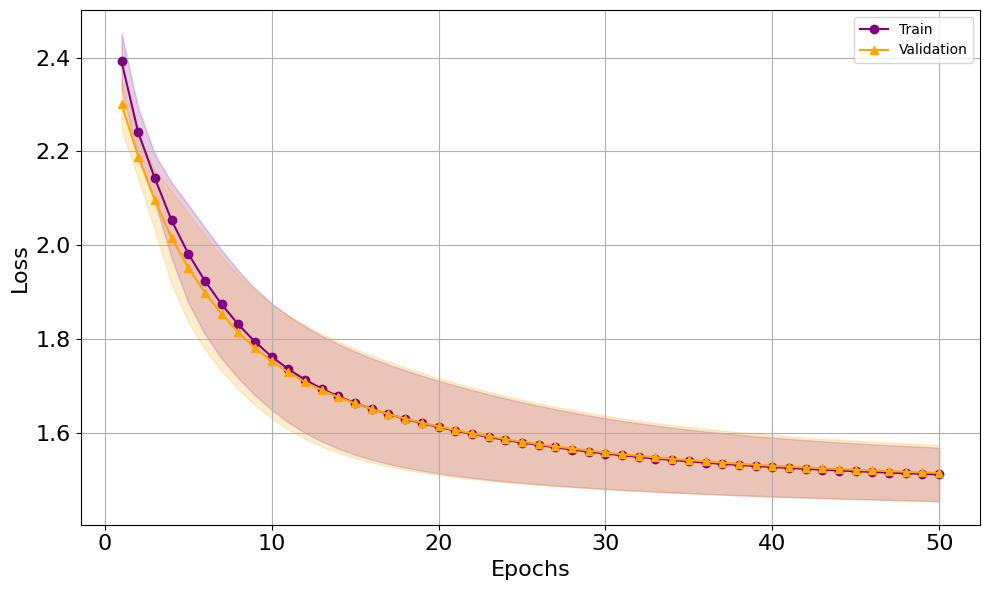

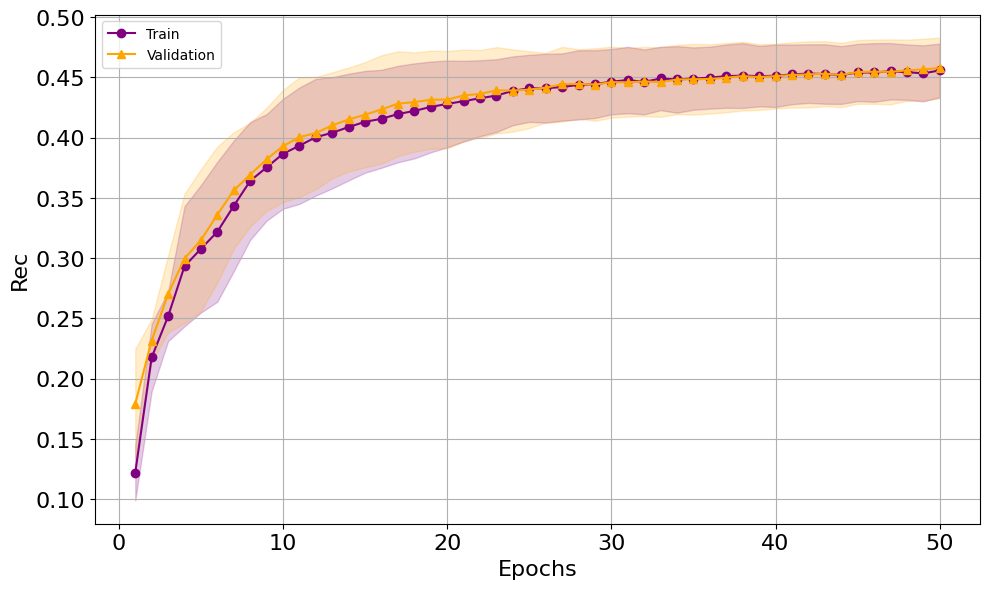

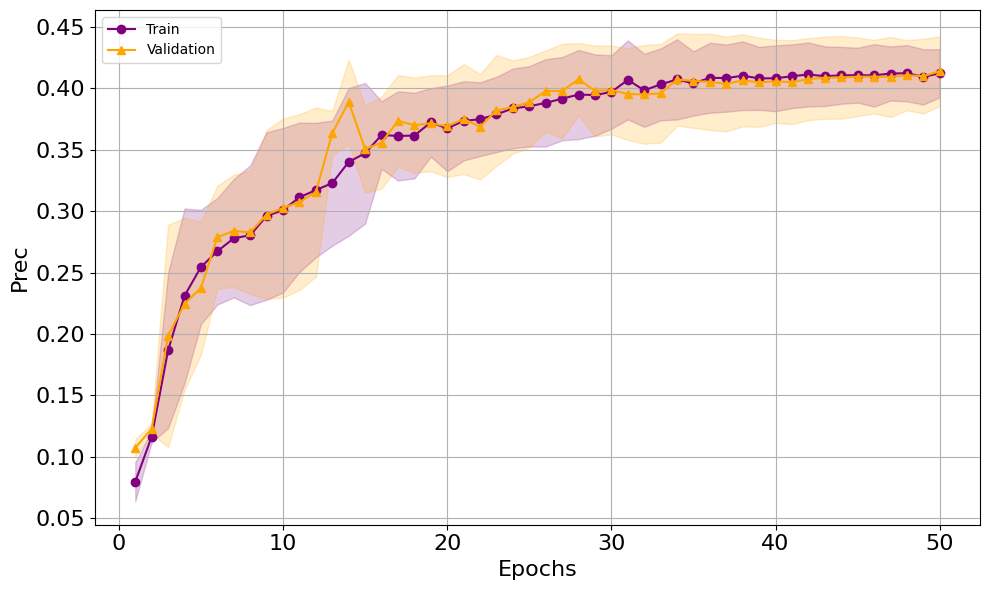

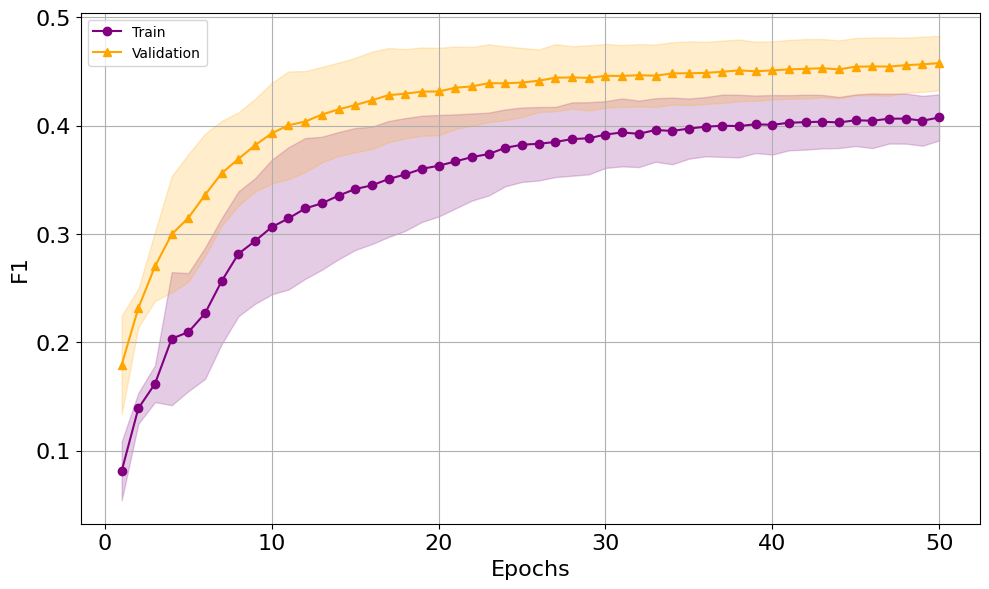

In [51]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [28]:
epochs = 50
device = "cpu"
dv_model = DVQuantumLinear(n_qubits=4, n_classes=11).to(device)

optimizer = torch.optim.Adam(dv_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

from torchinfo import summary
summary(dv_model)

Layer (type:depth-idx)                   Param #
DVQuantumLinear                          --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       55
Total params: 87
Trainable params: 87
Non-trainable params: 0

In [29]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 3 with val_f1 = 0.4818


In [30]:
device = "cpu"
test_dv_model = DVQuantumLinear(4, n_classes).to(device)

# test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

# test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_dv_model, test_loader, optimizer, criterion, device)
test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, dv_test_probs, dv_test_labels = evaluate_v2(test_dv_model, test_loader, optimizer, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 556/556 [03:23<00:00,  2.73it/s, loss=1.7201, acc

Test loss: 1.7201 | Test acc: 0.3913 | Test rec: 0.3913 | Test prec: 0.3683 | Test f1: 0.3913


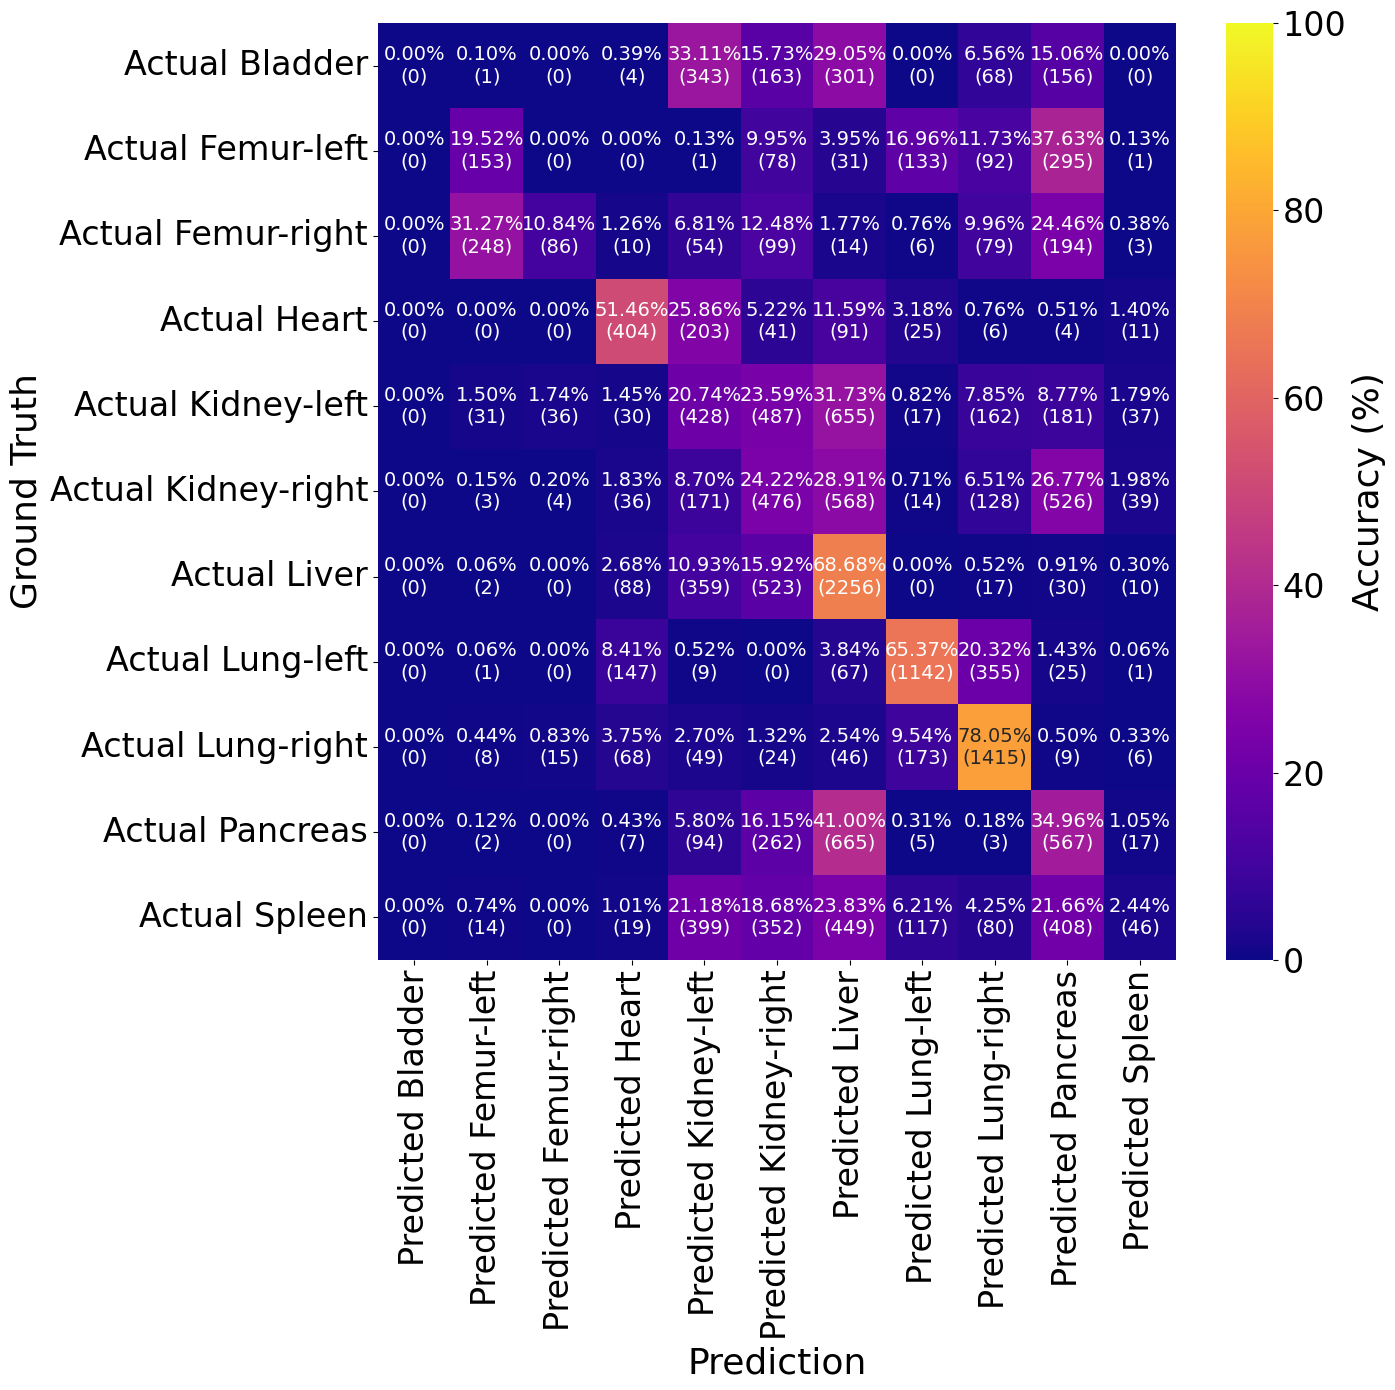

In [57]:
label_names = [
    "Bladder",
    "Femur-left",
    "Femur-right",
    "Heart",
    "Kidney-left",
    "Kidney-right",
    "Liver",
    "Lung-left",
    "Lung-right",
    "Pancreas",
    "Spleen",
]

plot_confusion_matrix(dv_test_labels, test_preds, label_names, model_name, binary=False)

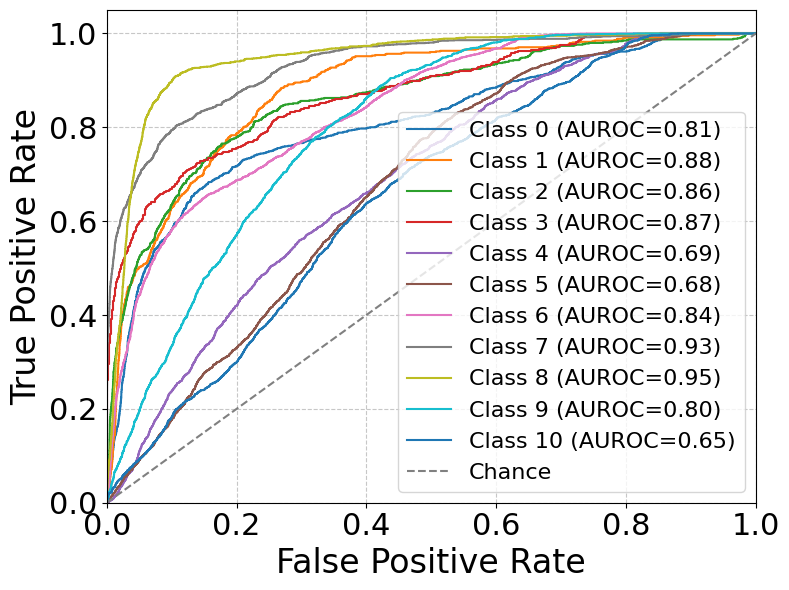

In [58]:
plot_auroc(dv_test_labels, dv_test_probs, model_name, binary=False)

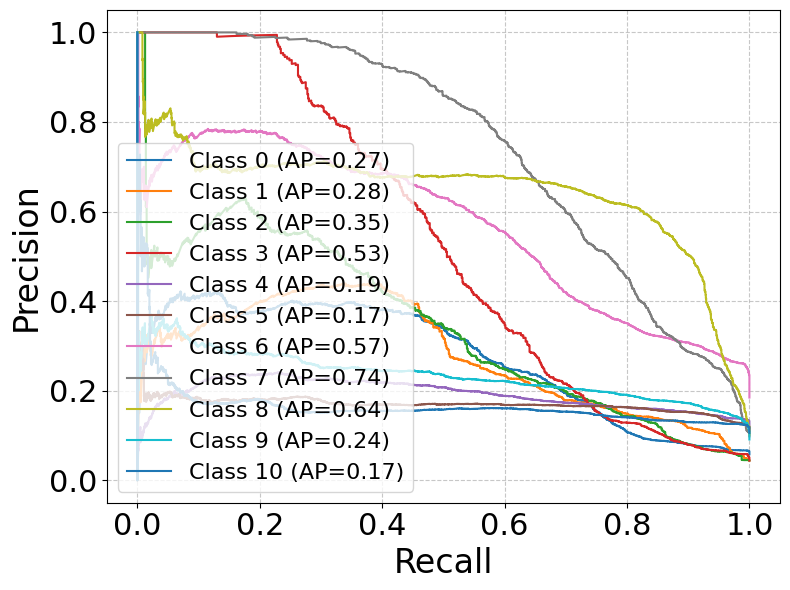

In [59]:
plot_prec(dv_test_labels, dv_test_probs, model_name, binary=False)

In [40]:
cam, outputs, predictions = gradcam_model(test_dv_model, x_test_tensor[0:16], quantum=True)
print(cam.shape)

torch.Size([16, 4])


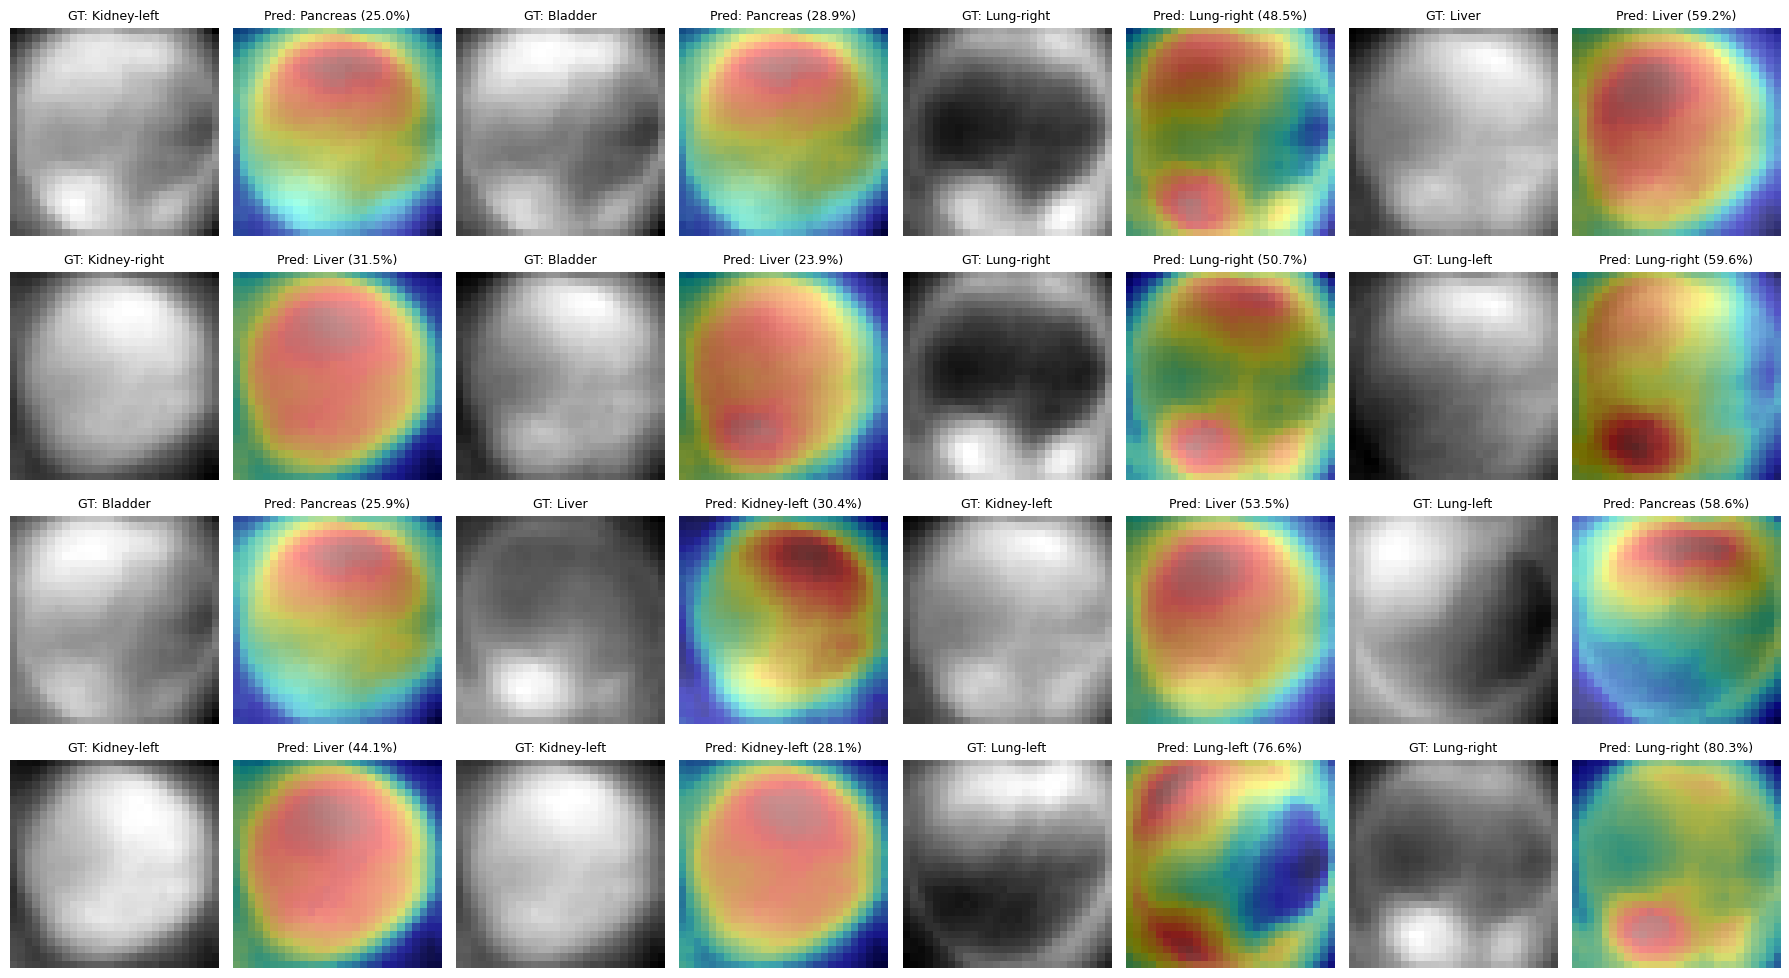

In [41]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## CLASSICAL MODEL

In [31]:
epochs = 50
device = "cpu"
model_name = "classical_organ"
classical_model = ClassicalModel(n_classes=11)

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       20
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       55
Total params: 75
Trainable params: 75
Non-trainable params: 0

In [54]:
run_kfold_training(ClassicalModel, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=True, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|█████| 108/108 [00:00<00:00, 685.99it/s, loss=2.2174, acc=0.3290]


Train loss: 2.3563 | Train acc: 0.1063 | Train rec: 0.1063 | Train prec: 0.2481 | Train f1: 0.1206
Val loss: 2.2174 | Val acc: 0.3290 | Val rec: 0.3290 | Val prec: 0.2632 | Val f1: 0.3290


Training: 100%|█████| 108/108 [00:00<00:00, 673.91it/s, loss=1.9713, acc=0.3782]


Train loss: 2.0865 | Train acc: 0.3750 | Train rec: 0.3750 | Train prec: 0.2623 | Train f1: 0.2658
Val loss: 1.9713 | Val acc: 0.3782 | Val rec: 0.3782 | Val prec: 0.1901 | Val f1: 0.3782


Training: 100%|█████| 108/108 [00:00<00:00, 573.59it/s, loss=1.8112, acc=0.3851]


Train loss: 1.8877 | Train acc: 0.3819 | Train rec: 0.3819 | Train prec: 0.2163 | Train f1: 0.2432
Val loss: 1.8112 | Val acc: 0.3851 | Val rec: 0.3851 | Val prec: 0.2002 | Val f1: 0.3851


Training: 100%|█████| 108/108 [00:00<00:00, 707.18it/s, loss=1.7118, acc=0.3961]


Train loss: 1.7609 | Train acc: 0.3841 | Train rec: 0.3841 | Train prec: 0.2180 | Train f1: 0.2623
Val loss: 1.7118 | Val acc: 0.3961 | Val rec: 0.3961 | Val prec: 0.2811 | Val f1: 0.3961


Training: 100%|█████| 108/108 [00:00<00:00, 659.72it/s, loss=1.6478, acc=0.4036]


Train loss: 1.6810 | Train acc: 0.3937 | Train rec: 0.3937 | Train prec: 0.2995 | Train f1: 0.2990
Val loss: 1.6478 | Val acc: 0.4036 | Val rec: 0.4036 | Val prec: 0.3240 | Val f1: 0.4036


Training: 100%|█████| 108/108 [00:00<00:00, 593.16it/s, loss=1.6008, acc=0.4091]


Train loss: 1.6263 | Train acc: 0.4065 | Train rec: 0.4065 | Train prec: 0.3465 | Train f1: 0.3255
Val loss: 1.6008 | Val acc: 0.4091 | Val rec: 0.4091 | Val prec: 0.3343 | Val f1: 0.4091


Training: 100%|█████| 108/108 [00:00<00:00, 632.77it/s, loss=1.5628, acc=0.4080]


Train loss: 1.5839 | Train acc: 0.4157 | Train rec: 0.4157 | Train prec: 0.3423 | Train f1: 0.3435
Val loss: 1.5628 | Val acc: 0.4080 | Val rec: 0.4080 | Val prec: 0.3470 | Val f1: 0.4080


Training: 100%|█████| 108/108 [00:00<00:00, 574.78it/s, loss=1.5305, acc=0.4126]


Train loss: 1.5493 | Train acc: 0.4162 | Train rec: 0.4162 | Train prec: 0.3498 | Train f1: 0.3452
Val loss: 1.5305 | Val acc: 0.4126 | Val rec: 0.4126 | Val prec: 0.3434 | Val f1: 0.4126


Training: 100%|█████| 108/108 [00:00<00:00, 626.20it/s, loss=1.5025, acc=0.4346]


Train loss: 1.5192 | Train acc: 0.4287 | Train rec: 0.4287 | Train prec: 0.3898 | Train f1: 0.3684
Val loss: 1.5025 | Val acc: 0.4346 | Val rec: 0.4346 | Val prec: 0.3851 | Val f1: 0.4346


Training: 100%|█████| 108/108 [00:00<00:00, 588.13it/s, loss=1.4781, acc=0.4505]


Train loss: 1.4935 | Train acc: 0.4492 | Train rec: 0.4492 | Train prec: 0.3894 | Train f1: 0.3906
Val loss: 1.4781 | Val acc: 0.4505 | Val rec: 0.4505 | Val prec: 0.3834 | Val f1: 0.4505


Training: 100%|█████| 108/108 [00:00<00:00, 652.78it/s, loss=1.4570, acc=0.4615]


Train loss: 1.4712 | Train acc: 0.4570 | Train rec: 0.4570 | Train prec: 0.3904 | Train f1: 0.3958
Val loss: 1.4570 | Val acc: 0.4615 | Val rec: 0.4615 | Val prec: 0.4282 | Val f1: 0.4615


Training: 100%|█████| 108/108 [00:00<00:00, 648.90it/s, loss=1.4392, acc=0.4601]


Train loss: 1.4520 | Train acc: 0.4711 | Train rec: 0.4711 | Train prec: 0.4160 | Train f1: 0.4138
Val loss: 1.4392 | Val acc: 0.4601 | Val rec: 0.4601 | Val prec: 0.4099 | Val f1: 0.4601


Training: 100%|█████| 108/108 [00:00<00:00, 632.66it/s, loss=1.4240, acc=0.4789]


Train loss: 1.4371 | Train acc: 0.4748 | Train rec: 0.4748 | Train prec: 0.4168 | Train f1: 0.4161
Val loss: 1.4240 | Val acc: 0.4789 | Val rec: 0.4789 | Val prec: 0.4102 | Val f1: 0.4789


Training: 100%|█████| 108/108 [00:00<00:00, 639.77it/s, loss=1.4118, acc=0.4876]


Train loss: 1.4247 | Train acc: 0.4815 | Train rec: 0.4815 | Train prec: 0.4174 | Train f1: 0.4233
Val loss: 1.4118 | Val acc: 0.4876 | Val rec: 0.4876 | Val prec: 0.4209 | Val f1: 0.4876


Training: 100%|█████| 108/108 [00:00<00:00, 687.59it/s, loss=1.4011, acc=0.4864]


Train loss: 1.4148 | Train acc: 0.4860 | Train rec: 0.4860 | Train prec: 0.4109 | Train f1: 0.4215
Val loss: 1.4011 | Val acc: 0.4864 | Val rec: 0.4864 | Val prec: 0.4150 | Val f1: 0.4864


Training: 100%|█████| 108/108 [00:00<00:00, 590.09it/s, loss=1.3925, acc=0.4887]


Train loss: 1.4067 | Train acc: 0.4860 | Train rec: 0.4860 | Train prec: 0.4102 | Train f1: 0.4219
Val loss: 1.3925 | Val acc: 0.4887 | Val rec: 0.4887 | Val prec: 0.4217 | Val f1: 0.4887


Training: 100%|█████| 108/108 [00:00<00:00, 585.32it/s, loss=1.3850, acc=0.4905]


Train loss: 1.3995 | Train acc: 0.4890 | Train rec: 0.4890 | Train prec: 0.4199 | Train f1: 0.4241
Val loss: 1.3850 | Val acc: 0.4905 | Val rec: 0.4905 | Val prec: 0.4297 | Val f1: 0.4905


Training: 100%|█████| 108/108 [00:00<00:00, 630.07it/s, loss=1.3787, acc=0.4893]


Train loss: 1.3938 | Train acc: 0.4918 | Train rec: 0.4918 | Train prec: 0.4272 | Train f1: 0.4270
Val loss: 1.3787 | Val acc: 0.4893 | Val rec: 0.4893 | Val prec: 0.4319 | Val f1: 0.4893


Training: 100%|█████| 108/108 [00:00<00:00, 707.06it/s, loss=1.3733, acc=0.4916]


Train loss: 1.3885 | Train acc: 0.4886 | Train rec: 0.4886 | Train prec: 0.4263 | Train f1: 0.4254
Val loss: 1.3733 | Val acc: 0.4916 | Val rec: 0.4916 | Val prec: 0.4412 | Val f1: 0.4916


Training: 100%|█████| 108/108 [00:00<00:00, 616.25it/s, loss=1.3689, acc=0.4922]


Train loss: 1.3844 | Train acc: 0.4936 | Train rec: 0.4936 | Train prec: 0.4328 | Train f1: 0.4292
Val loss: 1.3689 | Val acc: 0.4922 | Val rec: 0.4922 | Val prec: 0.4357 | Val f1: 0.4922


Training: 100%|█████| 108/108 [00:00<00:00, 666.54it/s, loss=1.3647, acc=0.4959]


Train loss: 1.3809 | Train acc: 0.4897 | Train rec: 0.4897 | Train prec: 0.4271 | Train f1: 0.4272
Val loss: 1.3647 | Val acc: 0.4959 | Val rec: 0.4959 | Val prec: 0.4427 | Val f1: 0.4959


Training: 100%|█████| 108/108 [00:00<00:00, 639.67it/s, loss=1.3615, acc=0.4962]


Train loss: 1.3780 | Train acc: 0.4932 | Train rec: 0.4932 | Train prec: 0.4346 | Train f1: 0.4299
Val loss: 1.3615 | Val acc: 0.4962 | Val rec: 0.4962 | Val prec: 0.4461 | Val f1: 0.4962


Training: 100%|█████| 108/108 [00:00<00:00, 630.91it/s, loss=1.3589, acc=0.4939]


Train loss: 1.3749 | Train acc: 0.4948 | Train rec: 0.4948 | Train prec: 0.4326 | Train f1: 0.4315
Val loss: 1.3589 | Val acc: 0.4939 | Val rec: 0.4939 | Val prec: 0.4418 | Val f1: 0.4939


Training: 100%|█████| 108/108 [00:00<00:00, 621.52it/s, loss=1.3561, acc=0.4951]


Train loss: 1.3730 | Train acc: 0.4931 | Train rec: 0.4931 | Train prec: 0.4297 | Train f1: 0.4297
Val loss: 1.3561 | Val acc: 0.4951 | Val rec: 0.4951 | Val prec: 0.4488 | Val f1: 0.4951


Training: 100%|█████| 108/108 [00:00<00:00, 675.96it/s, loss=1.3541, acc=0.4936]


Train loss: 1.3710 | Train acc: 0.4928 | Train rec: 0.4928 | Train prec: 0.4370 | Train f1: 0.4318
Val loss: 1.3541 | Val acc: 0.4936 | Val rec: 0.4936 | Val prec: 0.4423 | Val f1: 0.4936


Training: 100%|█████| 108/108 [00:00<00:00, 693.99it/s, loss=1.3522, acc=0.4957]


Train loss: 1.3691 | Train acc: 0.4931 | Train rec: 0.4931 | Train prec: 0.4345 | Train f1: 0.4318
Val loss: 1.3522 | Val acc: 0.4957 | Val rec: 0.4957 | Val prec: 0.4426 | Val f1: 0.4957


Training: 100%|█████| 108/108 [00:00<00:00, 655.60it/s, loss=1.3499, acc=0.4959]


Train loss: 1.3675 | Train acc: 0.4968 | Train rec: 0.4968 | Train prec: 0.4377 | Train f1: 0.4346
Val loss: 1.3499 | Val acc: 0.4959 | Val rec: 0.4959 | Val prec: 0.4454 | Val f1: 0.4959


Training: 100%|█████| 108/108 [00:00<00:00, 658.28it/s, loss=1.3482, acc=0.4951]


Train loss: 1.3658 | Train acc: 0.4939 | Train rec: 0.4939 | Train prec: 0.4316 | Train f1: 0.4322
Val loss: 1.3482 | Val acc: 0.4951 | Val rec: 0.4951 | Val prec: 0.4406 | Val f1: 0.4951


Training: 100%|█████| 108/108 [00:00<00:00, 657.42it/s, loss=1.3463, acc=0.4965]


Train loss: 1.3642 | Train acc: 0.4919 | Train rec: 0.4919 | Train prec: 0.4299 | Train f1: 0.4313
Val loss: 1.3463 | Val acc: 0.4965 | Val rec: 0.4965 | Val prec: 0.4424 | Val f1: 0.4965


Training: 100%|█████| 108/108 [00:00<00:00, 661.32it/s, loss=1.3442, acc=0.4945]


Train loss: 1.3627 | Train acc: 0.4929 | Train rec: 0.4929 | Train prec: 0.4329 | Train f1: 0.4326
Val loss: 1.3442 | Val acc: 0.4945 | Val rec: 0.4945 | Val prec: 0.4471 | Val f1: 0.4945


Training: 100%|█████| 108/108 [00:00<00:00, 664.78it/s, loss=1.3428, acc=0.4951]


Train loss: 1.3611 | Train acc: 0.4926 | Train rec: 0.4926 | Train prec: 0.4302 | Train f1: 0.4335
Val loss: 1.3428 | Val acc: 0.4951 | Val rec: 0.4951 | Val prec: 0.4467 | Val f1: 0.4951


Training: 100%|█████| 108/108 [00:00<00:00, 618.74it/s, loss=1.3413, acc=0.4959]


Train loss: 1.3600 | Train acc: 0.4955 | Train rec: 0.4955 | Train prec: 0.4334 | Train f1: 0.4362
Val loss: 1.3413 | Val acc: 0.4959 | Val rec: 0.4959 | Val prec: 0.4505 | Val f1: 0.4959


Training: 100%|█████| 108/108 [00:00<00:00, 641.92it/s, loss=1.3399, acc=0.4936]


Train loss: 1.3586 | Train acc: 0.4945 | Train rec: 0.4945 | Train prec: 0.4301 | Train f1: 0.4347
Val loss: 1.3399 | Val acc: 0.4936 | Val rec: 0.4936 | Val prec: 0.4378 | Val f1: 0.4936


Training: 100%|█████| 108/108 [00:00<00:00, 607.50it/s, loss=1.3389, acc=0.4991]


Train loss: 1.3572 | Train acc: 0.4939 | Train rec: 0.4939 | Train prec: 0.4314 | Train f1: 0.4360
Val loss: 1.3389 | Val acc: 0.4991 | Val rec: 0.4991 | Val prec: 0.4490 | Val f1: 0.4991


Training: 100%|█████| 108/108 [00:00<00:00, 642.66it/s, loss=1.3373, acc=0.4959]


Train loss: 1.3558 | Train acc: 0.4952 | Train rec: 0.4952 | Train prec: 0.4324 | Train f1: 0.4362
Val loss: 1.3373 | Val acc: 0.4959 | Val rec: 0.4959 | Val prec: 0.4521 | Val f1: 0.4959


Training: 100%|█████| 108/108 [00:00<00:00, 585.16it/s, loss=1.3361, acc=0.4962]


Train loss: 1.3547 | Train acc: 0.4935 | Train rec: 0.4935 | Train prec: 0.4288 | Train f1: 0.4356
Val loss: 1.3361 | Val acc: 0.4962 | Val rec: 0.4962 | Val prec: 0.4447 | Val f1: 0.4962


Training: 100%|█████| 108/108 [00:00<00:00, 591.50it/s, loss=1.3353, acc=0.5003]


Train loss: 1.3535 | Train acc: 0.4948 | Train rec: 0.4948 | Train prec: 0.4308 | Train f1: 0.4360
Val loss: 1.3353 | Val acc: 0.5003 | Val rec: 0.5003 | Val prec: 0.4522 | Val f1: 0.5003


Training: 100%|█████| 108/108 [00:00<00:00, 612.88it/s, loss=1.3330, acc=0.4965]


Train loss: 1.3524 | Train acc: 0.4958 | Train rec: 0.4958 | Train prec: 0.4325 | Train f1: 0.4400
Val loss: 1.3330 | Val acc: 0.4965 | Val rec: 0.4965 | Val prec: 0.4434 | Val f1: 0.4965


Training: 100%|█████| 108/108 [00:00<00:00, 673.27it/s, loss=1.3318, acc=0.5035]


Train loss: 1.3511 | Train acc: 0.4962 | Train rec: 0.4962 | Train prec: 0.4329 | Train f1: 0.4389
Val loss: 1.3318 | Val acc: 0.5035 | Val rec: 0.5035 | Val prec: 0.4527 | Val f1: 0.5035


Training: 100%|█████| 108/108 [00:00<00:00, 634.00it/s, loss=1.3310, acc=0.5000]


Train loss: 1.3498 | Train acc: 0.4975 | Train rec: 0.4975 | Train prec: 0.4341 | Train f1: 0.4412
Val loss: 1.3310 | Val acc: 0.5000 | Val rec: 0.5000 | Val prec: 0.4525 | Val f1: 0.5000


Training: 100%|█████| 108/108 [00:00<00:00, 619.72it/s, loss=1.3302, acc=0.5020]


Train loss: 1.3487 | Train acc: 0.4971 | Train rec: 0.4971 | Train prec: 0.4324 | Train f1: 0.4408
Val loss: 1.3302 | Val acc: 0.5020 | Val rec: 0.5020 | Val prec: 0.4545 | Val f1: 0.5020


Training: 100%|█████| 108/108 [00:00<00:00, 622.50it/s, loss=1.3283, acc=0.5017]


Train loss: 1.3477 | Train acc: 0.4981 | Train rec: 0.4981 | Train prec: 0.4383 | Train f1: 0.4432
Val loss: 1.3283 | Val acc: 0.5017 | Val rec: 0.5017 | Val prec: 0.4537 | Val f1: 0.5017


Training: 100%|█████| 108/108 [00:00<00:00, 638.97it/s, loss=1.3274, acc=0.4991]


Train loss: 1.3465 | Train acc: 0.4996 | Train rec: 0.4996 | Train prec: 0.4398 | Train f1: 0.4448
Val loss: 1.3274 | Val acc: 0.4991 | Val rec: 0.4991 | Val prec: 0.4526 | Val f1: 0.4991


Training: 100%|█████| 108/108 [00:00<00:00, 581.52it/s, loss=1.3266, acc=0.5075]


Train loss: 1.3454 | Train acc: 0.4984 | Train rec: 0.4984 | Train prec: 0.4427 | Train f1: 0.4461
Val loss: 1.3266 | Val acc: 0.5075 | Val rec: 0.5075 | Val prec: 0.4574 | Val f1: 0.5075


Training: 100%|█████| 108/108 [00:00<00:00, 642.62it/s, loss=1.3252, acc=0.5090]


Train loss: 1.3443 | Train acc: 0.5006 | Train rec: 0.5006 | Train prec: 0.4400 | Train f1: 0.4471
Val loss: 1.3252 | Val acc: 0.5090 | Val rec: 0.5090 | Val prec: 0.4636 | Val f1: 0.5090


Training: 100%|█████| 108/108 [00:00<00:00, 605.87it/s, loss=1.3247, acc=0.5064]


Train loss: 1.3432 | Train acc: 0.5036 | Train rec: 0.5036 | Train prec: 0.4482 | Train f1: 0.4508
Val loss: 1.3247 | Val acc: 0.5064 | Val rec: 0.5064 | Val prec: 0.4628 | Val f1: 0.5064


Training: 100%|█████| 108/108 [00:00<00:00, 655.11it/s, loss=1.3234, acc=0.5038]


Train loss: 1.3425 | Train acc: 0.5042 | Train rec: 0.5042 | Train prec: 0.4463 | Train f1: 0.4516
Val loss: 1.3234 | Val acc: 0.5038 | Val rec: 0.5038 | Val prec: 0.4627 | Val f1: 0.5038


Training: 100%|█████| 108/108 [00:00<00:00, 613.91it/s, loss=1.3234, acc=0.5026]


Train loss: 1.3412 | Train acc: 0.5046 | Train rec: 0.5046 | Train prec: 0.4517 | Train f1: 0.4543
Val loss: 1.3234 | Val acc: 0.5026 | Val rec: 0.5026 | Val prec: 0.4636 | Val f1: 0.5026


Training: 100%|█████| 108/108 [00:00<00:00, 608.70it/s, loss=1.3224, acc=0.5046]


Train loss: 1.3401 | Train acc: 0.5056 | Train rec: 0.5056 | Train prec: 0.4517 | Train f1: 0.4547
Val loss: 1.3224 | Val acc: 0.5046 | Val rec: 0.5046 | Val prec: 0.4630 | Val f1: 0.5046


Training: 100%|█████| 108/108 [00:00<00:00, 722.42it/s, loss=1.3205, acc=0.5049]


Train loss: 1.3392 | Train acc: 0.5048 | Train rec: 0.5048 | Train prec: 0.4516 | Train f1: 0.4556
Val loss: 1.3205 | Val acc: 0.5049 | Val rec: 0.5049 | Val prec: 0.4644 | Val f1: 0.5049

 Fold 2/3


Training: 100%|█████| 108/108 [00:00<00:00, 636.84it/s, loss=2.2353, acc=0.2112]


Train loss: 2.3690 | Train acc: 0.1649 | Train rec: 0.1649 | Train prec: 0.0760 | Train f1: 0.0935
Val loss: 2.2353 | Val acc: 0.2112 | Val rec: 0.2112 | Val prec: 0.0869 | Val f1: 0.2112


Training: 100%|█████| 108/108 [00:00<00:00, 639.49it/s, loss=1.9583, acc=0.3626]


Train loss: 2.0935 | Train acc: 0.2650 | Train rec: 0.2650 | Train prec: 0.2536 | Train f1: 0.2024
Val loss: 1.9583 | Val acc: 0.3626 | Val rec: 0.3626 | Val prec: 0.2631 | Val f1: 0.3626


Training: 100%|█████| 108/108 [00:00<00:00, 694.65it/s, loss=1.7927, acc=0.3851]


Train loss: 1.8652 | Train acc: 0.3827 | Train rec: 0.3827 | Train prec: 0.2425 | Train f1: 0.2909
Val loss: 1.7927 | Val acc: 0.3851 | Val rec: 0.3851 | Val prec: 0.2291 | Val f1: 0.3851


Training: 100%|█████| 108/108 [00:00<00:00, 631.82it/s, loss=1.7073, acc=0.3958]


Train loss: 1.7451 | Train acc: 0.4002 | Train rec: 0.4002 | Train prec: 0.2399 | Train f1: 0.2923
Val loss: 1.7073 | Val acc: 0.3958 | Val rec: 0.3958 | Val prec: 0.2344 | Val f1: 0.3958


Training: 100%|█████| 108/108 [00:00<00:00, 693.36it/s, loss=1.6493, acc=0.4094]


Train loss: 1.6765 | Train acc: 0.4093 | Train rec: 0.4093 | Train prec: 0.2500 | Train f1: 0.3011
Val loss: 1.6493 | Val acc: 0.4094 | Val rec: 0.4094 | Val prec: 0.2498 | Val f1: 0.4094


Training: 100%|█████| 108/108 [00:00<00:00, 613.04it/s, loss=1.6026, acc=0.4294]


Train loss: 1.6260 | Train acc: 0.4246 | Train rec: 0.4246 | Train prec: 0.3148 | Train f1: 0.3225
Val loss: 1.6026 | Val acc: 0.4294 | Val rec: 0.4294 | Val prec: 0.3190 | Val f1: 0.4294


Training: 100%|█████| 108/108 [00:00<00:00, 591.56it/s, loss=1.5609, acc=0.4456]


Train loss: 1.5829 | Train acc: 0.4421 | Train rec: 0.4421 | Train prec: 0.3274 | Train f1: 0.3454
Val loss: 1.5609 | Val acc: 0.4456 | Val rec: 0.4456 | Val prec: 0.3257 | Val f1: 0.4456


Training: 100%|█████| 108/108 [00:00<00:00, 735.87it/s, loss=1.5257, acc=0.4595]


Train loss: 1.5442 | Train acc: 0.4576 | Train rec: 0.4576 | Train prec: 0.3436 | Train f1: 0.3655
Val loss: 1.5257 | Val acc: 0.4595 | Val rec: 0.4595 | Val prec: 0.3701 | Val f1: 0.4595


Training: 100%|█████| 108/108 [00:00<00:00, 631.00it/s, loss=1.4954, acc=0.4693]


Train loss: 1.5110 | Train acc: 0.4666 | Train rec: 0.4666 | Train prec: 0.3537 | Train f1: 0.3787
Val loss: 1.4954 | Val acc: 0.4693 | Val rec: 0.4693 | Val prec: 0.3461 | Val f1: 0.4693


Training: 100%|█████| 108/108 [00:00<00:00, 624.79it/s, loss=1.4701, acc=0.4783]


Train loss: 1.4827 | Train acc: 0.4747 | Train rec: 0.4747 | Train prec: 0.4165 | Train f1: 0.3913
Val loss: 1.4701 | Val acc: 0.4783 | Val rec: 0.4783 | Val prec: 0.4184 | Val f1: 0.4783


Training: 100%|█████| 108/108 [00:00<00:00, 656.87it/s, loss=1.4490, acc=0.4890]


Train loss: 1.4593 | Train acc: 0.4841 | Train rec: 0.4841 | Train prec: 0.4034 | Train f1: 0.4098
Val loss: 1.4490 | Val acc: 0.4890 | Val rec: 0.4890 | Val prec: 0.4335 | Val f1: 0.4890


Training: 100%|█████| 108/108 [00:00<00:00, 581.61it/s, loss=1.4324, acc=0.4919]


Train loss: 1.4401 | Train acc: 0.4906 | Train rec: 0.4906 | Train prec: 0.4066 | Train f1: 0.4197
Val loss: 1.4324 | Val acc: 0.4919 | Val rec: 0.4919 | Val prec: 0.4167 | Val f1: 0.4919


Training: 100%|█████| 108/108 [00:00<00:00, 651.03it/s, loss=1.4187, acc=0.4954]


Train loss: 1.4239 | Train acc: 0.4948 | Train rec: 0.4948 | Train prec: 0.4663 | Train f1: 0.4273
Val loss: 1.4187 | Val acc: 0.4954 | Val rec: 0.4954 | Val prec: 0.4418 | Val f1: 0.4954


Training: 100%|█████| 108/108 [00:00<00:00, 609.57it/s, loss=1.4070, acc=0.4968]


Train loss: 1.4105 | Train acc: 0.4981 | Train rec: 0.4981 | Train prec: 0.4277 | Train f1: 0.4312
Val loss: 1.4070 | Val acc: 0.4968 | Val rec: 0.4968 | Val prec: 0.4773 | Val f1: 0.4968


Training: 100%|█████| 108/108 [00:00<00:00, 645.80it/s, loss=1.3972, acc=0.5006]


Train loss: 1.3987 | Train acc: 0.5004 | Train rec: 0.5004 | Train prec: 0.4549 | Train f1: 0.4359
Val loss: 1.3972 | Val acc: 0.5006 | Val rec: 0.5006 | Val prec: 0.4665 | Val f1: 0.5006


Training: 100%|█████| 108/108 [00:00<00:00, 674.45it/s, loss=1.3883, acc=0.5038]


Train loss: 1.3885 | Train acc: 0.5056 | Train rec: 0.5056 | Train prec: 0.4605 | Train f1: 0.4468
Val loss: 1.3883 | Val acc: 0.5038 | Val rec: 0.5038 | Val prec: 0.4679 | Val f1: 0.5038


Training: 100%|█████| 108/108 [00:00<00:00, 628.01it/s, loss=1.3801, acc=0.5220]


Train loss: 1.3790 | Train acc: 0.5117 | Train rec: 0.5117 | Train prec: 0.4633 | Train f1: 0.4565
Val loss: 1.3801 | Val acc: 0.5220 | Val rec: 0.5220 | Val prec: 0.4733 | Val f1: 0.5220


Training: 100%|█████| 108/108 [00:00<00:00, 587.59it/s, loss=1.3734, acc=0.5231]


Train loss: 1.3708 | Train acc: 0.5233 | Train rec: 0.5233 | Train prec: 0.4657 | Train f1: 0.4703
Val loss: 1.3734 | Val acc: 0.5231 | Val rec: 0.5231 | Val prec: 0.4785 | Val f1: 0.5231


Training: 100%|█████| 108/108 [00:00<00:00, 595.14it/s, loss=1.3666, acc=0.5275]


Train loss: 1.3634 | Train acc: 0.5252 | Train rec: 0.5252 | Train prec: 0.4723 | Train f1: 0.4741
Val loss: 1.3666 | Val acc: 0.5275 | Val rec: 0.5275 | Val prec: 0.4762 | Val f1: 0.5275


Training: 100%|█████| 108/108 [00:00<00:00, 647.06it/s, loss=1.3605, acc=0.5301]


Train loss: 1.3563 | Train acc: 0.5282 | Train rec: 0.5282 | Train prec: 0.4693 | Train f1: 0.4760
Val loss: 1.3605 | Val acc: 0.5301 | Val rec: 0.5301 | Val prec: 0.4823 | Val f1: 0.5301


Training: 100%|█████| 108/108 [00:00<00:00, 615.04it/s, loss=1.3551, acc=0.5321]


Train loss: 1.3500 | Train acc: 0.5312 | Train rec: 0.5312 | Train prec: 0.4716 | Train f1: 0.4804
Val loss: 1.3551 | Val acc: 0.5321 | Val rec: 0.5321 | Val prec: 0.4871 | Val f1: 0.5321


Training: 100%|█████| 108/108 [00:00<00:00, 593.63it/s, loss=1.3508, acc=0.5321]


Train loss: 1.3438 | Train acc: 0.5308 | Train rec: 0.5308 | Train prec: 0.4769 | Train f1: 0.4810
Val loss: 1.3508 | Val acc: 0.5321 | Val rec: 0.5321 | Val prec: 0.4832 | Val f1: 0.5321


Training: 100%|█████| 108/108 [00:00<00:00, 721.10it/s, loss=1.3450, acc=0.5373]


Train loss: 1.3381 | Train acc: 0.5318 | Train rec: 0.5318 | Train prec: 0.4741 | Train f1: 0.4803
Val loss: 1.3450 | Val acc: 0.5373 | Val rec: 0.5373 | Val prec: 0.4885 | Val f1: 0.5373


Training: 100%|█████| 108/108 [00:00<00:00, 640.73it/s, loss=1.3401, acc=0.5367]


Train loss: 1.3328 | Train acc: 0.5379 | Train rec: 0.5379 | Train prec: 0.4799 | Train f1: 0.4876
Val loss: 1.3401 | Val acc: 0.5367 | Val rec: 0.5367 | Val prec: 0.4915 | Val f1: 0.5367


Training: 100%|█████| 108/108 [00:00<00:00, 639.31it/s, loss=1.3357, acc=0.5379]


Train loss: 1.3273 | Train acc: 0.5375 | Train rec: 0.5375 | Train prec: 0.4816 | Train f1: 0.4870
Val loss: 1.3357 | Val acc: 0.5379 | Val rec: 0.5379 | Val prec: 0.4892 | Val f1: 0.5379


Training: 100%|█████| 108/108 [00:00<00:00, 681.00it/s, loss=1.3312, acc=0.5382]


Train loss: 1.3223 | Train acc: 0.5409 | Train rec: 0.5409 | Train prec: 0.4842 | Train f1: 0.4904
Val loss: 1.3312 | Val acc: 0.5382 | Val rec: 0.5382 | Val prec: 0.4926 | Val f1: 0.5382


Training: 100%|█████| 108/108 [00:00<00:00, 640.49it/s, loss=1.3268, acc=0.5394]


Train loss: 1.3175 | Train acc: 0.5420 | Train rec: 0.5420 | Train prec: 0.4881 | Train f1: 0.4929
Val loss: 1.3268 | Val acc: 0.5394 | Val rec: 0.5394 | Val prec: 0.4925 | Val f1: 0.5394


Training: 100%|█████| 108/108 [00:00<00:00, 666.49it/s, loss=1.3227, acc=0.5420]


Train loss: 1.3127 | Train acc: 0.5434 | Train rec: 0.5434 | Train prec: 0.4844 | Train f1: 0.4914
Val loss: 1.3227 | Val acc: 0.5420 | Val rec: 0.5420 | Val prec: 0.4966 | Val f1: 0.5420


Training: 100%|█████| 108/108 [00:00<00:00, 594.79it/s, loss=1.3183, acc=0.5408]


Train loss: 1.3078 | Train acc: 0.5447 | Train rec: 0.5447 | Train prec: 0.4897 | Train f1: 0.4942
Val loss: 1.3183 | Val acc: 0.5408 | Val rec: 0.5408 | Val prec: 0.4910 | Val f1: 0.5408


Training: 100%|█████| 108/108 [00:00<00:00, 697.62it/s, loss=1.3150, acc=0.5388]


Train loss: 1.3030 | Train acc: 0.5444 | Train rec: 0.5444 | Train prec: 0.4873 | Train f1: 0.4924
Val loss: 1.3150 | Val acc: 0.5388 | Val rec: 0.5388 | Val prec: 0.4874 | Val f1: 0.5388


Training: 100%|█████| 108/108 [00:00<00:00, 659.02it/s, loss=1.3110, acc=0.5422]


Train loss: 1.2983 | Train acc: 0.5456 | Train rec: 0.5456 | Train prec: 0.4872 | Train f1: 0.4930
Val loss: 1.3110 | Val acc: 0.5422 | Val rec: 0.5422 | Val prec: 0.4941 | Val f1: 0.5422


Training: 100%|█████| 108/108 [00:00<00:00, 695.80it/s, loss=1.3074, acc=0.5443]


Train loss: 1.2940 | Train acc: 0.5466 | Train rec: 0.5466 | Train prec: 0.4918 | Train f1: 0.4953
Val loss: 1.3074 | Val acc: 0.5443 | Val rec: 0.5443 | Val prec: 0.4949 | Val f1: 0.5443


Training: 100%|█████| 108/108 [00:00<00:00, 643.29it/s, loss=1.3037, acc=0.5448]


Train loss: 1.2898 | Train acc: 0.5480 | Train rec: 0.5480 | Train prec: 0.4950 | Train f1: 0.4960
Val loss: 1.3037 | Val acc: 0.5448 | Val rec: 0.5448 | Val prec: 0.4958 | Val f1: 0.5448


Training: 100%|█████| 108/108 [00:00<00:00, 704.14it/s, loss=1.3007, acc=0.5434]


Train loss: 1.2859 | Train acc: 0.5485 | Train rec: 0.5485 | Train prec: 0.4944 | Train f1: 0.4958
Val loss: 1.3007 | Val acc: 0.5434 | Val rec: 0.5434 | Val prec: 0.4932 | Val f1: 0.5434


Training: 100%|█████| 108/108 [00:00<00:00, 606.38it/s, loss=1.2976, acc=0.5425]


Train loss: 1.2827 | Train acc: 0.5508 | Train rec: 0.5508 | Train prec: 0.4993 | Train f1: 0.5003
Val loss: 1.2976 | Val acc: 0.5425 | Val rec: 0.5425 | Val prec: 0.4915 | Val f1: 0.5425


Training: 100%|█████| 108/108 [00:00<00:00, 624.11it/s, loss=1.2952, acc=0.5437]


Train loss: 1.2790 | Train acc: 0.5498 | Train rec: 0.5498 | Train prec: 0.4924 | Train f1: 0.4967
Val loss: 1.2952 | Val acc: 0.5437 | Val rec: 0.5437 | Val prec: 0.4972 | Val f1: 0.5437


Training: 100%|█████| 108/108 [00:00<00:00, 644.69it/s, loss=1.2924, acc=0.5428]


Train loss: 1.2760 | Train acc: 0.5522 | Train rec: 0.5522 | Train prec: 0.4979 | Train f1: 0.5006
Val loss: 1.2924 | Val acc: 0.5428 | Val rec: 0.5428 | Val prec: 0.4956 | Val f1: 0.5428


Training: 100%|█████| 108/108 [00:00<00:00, 656.08it/s, loss=1.2898, acc=0.5451]


Train loss: 1.2734 | Train acc: 0.5525 | Train rec: 0.5525 | Train prec: 0.4971 | Train f1: 0.5007
Val loss: 1.2898 | Val acc: 0.5451 | Val rec: 0.5451 | Val prec: 0.4993 | Val f1: 0.5451


Training: 100%|█████| 108/108 [00:00<00:00, 639.03it/s, loss=1.2868, acc=0.5440]


Train loss: 1.2704 | Train acc: 0.5515 | Train rec: 0.5515 | Train prec: 0.5002 | Train f1: 0.5013
Val loss: 1.2868 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.4915 | Val f1: 0.5440


Training: 100%|█████| 108/108 [00:00<00:00, 628.93it/s, loss=1.2853, acc=0.5454]


Train loss: 1.2674 | Train acc: 0.5531 | Train rec: 0.5531 | Train prec: 0.4963 | Train f1: 0.5014
Val loss: 1.2853 | Val acc: 0.5454 | Val rec: 0.5454 | Val prec: 0.5005 | Val f1: 0.5454


Training: 100%|█████| 108/108 [00:00<00:00, 626.09it/s, loss=1.2827, acc=0.5463]


Train loss: 1.2651 | Train acc: 0.5541 | Train rec: 0.5541 | Train prec: 0.4951 | Train f1: 0.5005
Val loss: 1.2827 | Val acc: 0.5463 | Val rec: 0.5463 | Val prec: 0.5004 | Val f1: 0.5463


Training: 100%|█████| 108/108 [00:00<00:00, 657.10it/s, loss=1.2803, acc=0.5431]


Train loss: 1.2625 | Train acc: 0.5561 | Train rec: 0.5561 | Train prec: 0.5044 | Train f1: 0.5056
Val loss: 1.2803 | Val acc: 0.5431 | Val rec: 0.5431 | Val prec: 0.4976 | Val f1: 0.5431


Training: 100%|█████| 108/108 [00:00<00:00, 620.03it/s, loss=1.2784, acc=0.5451]


Train loss: 1.2609 | Train acc: 0.5522 | Train rec: 0.5522 | Train prec: 0.4952 | Train f1: 0.5020
Val loss: 1.2784 | Val acc: 0.5451 | Val rec: 0.5451 | Val prec: 0.4983 | Val f1: 0.5451


Training: 100%|█████| 108/108 [00:00<00:00, 624.59it/s, loss=1.2763, acc=0.5448]


Train loss: 1.2586 | Train acc: 0.5543 | Train rec: 0.5543 | Train prec: 0.4995 | Train f1: 0.5028
Val loss: 1.2763 | Val acc: 0.5448 | Val rec: 0.5448 | Val prec: 0.4971 | Val f1: 0.5448


Training: 100%|█████| 108/108 [00:00<00:00, 703.53it/s, loss=1.2745, acc=0.5480]


Train loss: 1.2567 | Train acc: 0.5541 | Train rec: 0.5541 | Train prec: 0.4991 | Train f1: 0.5045
Val loss: 1.2745 | Val acc: 0.5480 | Val rec: 0.5480 | Val prec: 0.5021 | Val f1: 0.5480


Training: 100%|█████| 108/108 [00:00<00:00, 597.59it/s, loss=1.2724, acc=0.5495]


Train loss: 1.2545 | Train acc: 0.5551 | Train rec: 0.5551 | Train prec: 0.4960 | Train f1: 0.5037
Val loss: 1.2724 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.5067 | Val f1: 0.5495


Training: 100%|█████| 108/108 [00:00<00:00, 648.57it/s, loss=1.2711, acc=0.5472]


Train loss: 1.2529 | Train acc: 0.5534 | Train rec: 0.5534 | Train prec: 0.4958 | Train f1: 0.5025
Val loss: 1.2711 | Val acc: 0.5472 | Val rec: 0.5472 | Val prec: 0.5012 | Val f1: 0.5472


Training: 100%|█████| 108/108 [00:00<00:00, 643.38it/s, loss=1.2691, acc=0.5489]


Train loss: 1.2513 | Train acc: 0.5548 | Train rec: 0.5548 | Train prec: 0.5005 | Train f1: 0.5061
Val loss: 1.2691 | Val acc: 0.5489 | Val rec: 0.5489 | Val prec: 0.5048 | Val f1: 0.5489


Training: 100%|█████| 108/108 [00:00<00:00, 636.56it/s, loss=1.2675, acc=0.5483]


Train loss: 1.2495 | Train acc: 0.5556 | Train rec: 0.5556 | Train prec: 0.4977 | Train f1: 0.5065
Val loss: 1.2675 | Val acc: 0.5483 | Val rec: 0.5483 | Val prec: 0.5039 | Val f1: 0.5483


Training: 100%|█████| 108/108 [00:00<00:00, 698.45it/s, loss=1.2664, acc=0.5492]


Train loss: 1.2478 | Train acc: 0.5525 | Train rec: 0.5525 | Train prec: 0.4958 | Train f1: 0.5031
Val loss: 1.2664 | Val acc: 0.5492 | Val rec: 0.5492 | Val prec: 0.4985 | Val f1: 0.5492

 Fold 3/3


Training: 100%|█████| 108/108 [00:00<00:00, 623.72it/s, loss=2.2307, acc=0.2758]


Train loss: 2.3059 | Train acc: 0.2021 | Train rec: 0.2021 | Train prec: 0.1357 | Train f1: 0.1180
Val loss: 2.2307 | Val acc: 0.2758 | Val rec: 0.2758 | Val prec: 0.1586 | Val f1: 0.2758


Training: 100%|█████| 108/108 [00:00<00:00, 570.79it/s, loss=2.0826, acc=0.3319]


Train loss: 2.1573 | Train acc: 0.2975 | Train rec: 0.2975 | Train prec: 0.2878 | Train f1: 0.1917
Val loss: 2.0826 | Val acc: 0.3319 | Val rec: 0.3319 | Val prec: 0.2686 | Val f1: 0.3319


Training: 100%|█████| 108/108 [00:00<00:00, 651.90it/s, loss=1.9008, acc=0.4022]


Train loss: 1.9912 | Train acc: 0.3793 | Train rec: 0.3793 | Train prec: 0.2652 | Train f1: 0.2858
Val loss: 1.9008 | Val acc: 0.4022 | Val rec: 0.4022 | Val prec: 0.2602 | Val f1: 0.4022


Training: 100%|█████| 108/108 [00:00<00:00, 616.03it/s, loss=1.7328, acc=0.4193]


Train loss: 1.8062 | Train acc: 0.4183 | Train rec: 0.4183 | Train prec: 0.3310 | Train f1: 0.3086
Val loss: 1.7328 | Val acc: 0.4193 | Val rec: 0.4193 | Val prec: 0.3334 | Val f1: 0.4193


Training: 100%|█████| 108/108 [00:00<00:00, 696.34it/s, loss=1.6266, acc=0.4378]


Train loss: 1.6670 | Train acc: 0.4339 | Train rec: 0.4339 | Train prec: 0.3255 | Train f1: 0.3323
Val loss: 1.6266 | Val acc: 0.4378 | Val rec: 0.4378 | Val prec: 0.3221 | Val f1: 0.4378


Training: 100%|█████| 108/108 [00:00<00:00, 677.97it/s, loss=1.5592, acc=0.4528]


Train loss: 1.5791 | Train acc: 0.4497 | Train rec: 0.4497 | Train prec: 0.3307 | Train f1: 0.3581
Val loss: 1.5592 | Val acc: 0.4528 | Val rec: 0.4528 | Val prec: 0.3206 | Val f1: 0.4528


Training: 100%|█████| 108/108 [00:00<00:00, 628.57it/s, loss=1.5143, acc=0.4647]


Train loss: 1.5209 | Train acc: 0.4611 | Train rec: 0.4611 | Train prec: 0.3464 | Train f1: 0.3731
Val loss: 1.5143 | Val acc: 0.4647 | Val rec: 0.4647 | Val prec: 0.3479 | Val f1: 0.4647


Training: 100%|█████| 108/108 [00:00<00:00, 622.98it/s, loss=1.4838, acc=0.4780]


Train loss: 1.4819 | Train acc: 0.4766 | Train rec: 0.4766 | Train prec: 0.3861 | Train f1: 0.3958
Val loss: 1.4838 | Val acc: 0.4780 | Val rec: 0.4780 | Val prec: 0.3747 | Val f1: 0.4780


Training: 100%|█████| 108/108 [00:00<00:00, 600.17it/s, loss=1.4631, acc=0.4913]


Train loss: 1.4547 | Train acc: 0.4877 | Train rec: 0.4877 | Train prec: 0.3829 | Train f1: 0.4091
Val loss: 1.4631 | Val acc: 0.4913 | Val rec: 0.4913 | Val prec: 0.3952 | Val f1: 0.4913


Training: 100%|█████| 108/108 [00:00<00:00, 563.34it/s, loss=1.4479, acc=0.4971]


Train loss: 1.4354 | Train acc: 0.4980 | Train rec: 0.4980 | Train prec: 0.4083 | Train f1: 0.4179
Val loss: 1.4479 | Val acc: 0.4971 | Val rec: 0.4971 | Val prec: 0.4009 | Val f1: 0.4971


Training: 100%|█████| 108/108 [00:00<00:00, 647.84it/s, loss=1.4369, acc=0.5014]


Train loss: 1.4210 | Train acc: 0.5020 | Train rec: 0.5020 | Train prec: 0.4176 | Train f1: 0.4259
Val loss: 1.4369 | Val acc: 0.5014 | Val rec: 0.5014 | Val prec: 0.4213 | Val f1: 0.5014


Training: 100%|█████| 108/108 [00:00<00:00, 615.62it/s, loss=1.4282, acc=0.5058]


Train loss: 1.4103 | Train acc: 0.5058 | Train rec: 0.5058 | Train prec: 0.4119 | Train f1: 0.4289
Val loss: 1.4282 | Val acc: 0.5058 | Val rec: 0.5058 | Val prec: 0.4407 | Val f1: 0.5058


Training: 100%|█████| 108/108 [00:00<00:00, 592.24it/s, loss=1.4214, acc=0.5075]


Train loss: 1.4018 | Train acc: 0.5091 | Train rec: 0.5091 | Train prec: 0.4158 | Train f1: 0.4347
Val loss: 1.4214 | Val acc: 0.5075 | Val rec: 0.5075 | Val prec: 0.4275 | Val f1: 0.5075


Training: 100%|█████| 108/108 [00:00<00:00, 562.94it/s, loss=1.4151, acc=0.5168]


Train loss: 1.3950 | Train acc: 0.5111 | Train rec: 0.5111 | Train prec: 0.4280 | Train f1: 0.4339
Val loss: 1.4151 | Val acc: 0.5168 | Val rec: 0.5168 | Val prec: 0.4759 | Val f1: 0.5168


Training: 100%|█████| 108/108 [00:00<00:00, 653.91it/s, loss=1.4097, acc=0.5150]


Train loss: 1.3886 | Train acc: 0.5162 | Train rec: 0.5162 | Train prec: 0.4293 | Train f1: 0.4419
Val loss: 1.4097 | Val acc: 0.5150 | Val rec: 0.5150 | Val prec: 0.4574 | Val f1: 0.5150


Training: 100%|█████| 108/108 [00:00<00:00, 599.51it/s, loss=1.4052, acc=0.5191]


Train loss: 1.3837 | Train acc: 0.5163 | Train rec: 0.5163 | Train prec: 0.4293 | Train f1: 0.4428
Val loss: 1.4052 | Val acc: 0.5191 | Val rec: 0.5191 | Val prec: 0.4645 | Val f1: 0.5191


Training: 100%|█████| 108/108 [00:00<00:00, 677.05it/s, loss=1.4004, acc=0.5168]


Train loss: 1.3789 | Train acc: 0.5213 | Train rec: 0.5213 | Train prec: 0.4393 | Train f1: 0.4470
Val loss: 1.4004 | Val acc: 0.5168 | Val rec: 0.5168 | Val prec: 0.4565 | Val f1: 0.5168


Training: 100%|█████| 108/108 [00:00<00:00, 634.51it/s, loss=1.3967, acc=0.5220]


Train loss: 1.3747 | Train acc: 0.5207 | Train rec: 0.5207 | Train prec: 0.4403 | Train f1: 0.4452
Val loss: 1.3967 | Val acc: 0.5220 | Val rec: 0.5220 | Val prec: 0.4615 | Val f1: 0.5220


Training: 100%|█████| 108/108 [00:00<00:00, 628.13it/s, loss=1.3925, acc=0.5246]


Train loss: 1.3716 | Train acc: 0.5242 | Train rec: 0.5242 | Train prec: 0.4573 | Train f1: 0.4493
Val loss: 1.3925 | Val acc: 0.5246 | Val rec: 0.5246 | Val prec: 0.4843 | Val f1: 0.5246


Training: 100%|█████| 108/108 [00:00<00:00, 685.54it/s, loss=1.3892, acc=0.5229]


Train loss: 1.3680 | Train acc: 0.5258 | Train rec: 0.5258 | Train prec: 0.4346 | Train f1: 0.4517
Val loss: 1.3892 | Val acc: 0.5229 | Val rec: 0.5229 | Val prec: 0.4512 | Val f1: 0.5229


Training: 100%|█████| 108/108 [00:00<00:00, 649.55it/s, loss=1.3860, acc=0.5275]


Train loss: 1.3643 | Train acc: 0.5260 | Train rec: 0.5260 | Train prec: 0.4625 | Train f1: 0.4503
Val loss: 1.3860 | Val acc: 0.5275 | Val rec: 0.5275 | Val prec: 0.4542 | Val f1: 0.5275


Training: 100%|█████| 108/108 [00:00<00:00, 566.08it/s, loss=1.3828, acc=0.5295]


Train loss: 1.3615 | Train acc: 0.5269 | Train rec: 0.5269 | Train prec: 0.4514 | Train f1: 0.4510
Val loss: 1.3828 | Val acc: 0.5295 | Val rec: 0.5295 | Val prec: 0.4812 | Val f1: 0.5295


Training: 100%|█████| 108/108 [00:00<00:00, 639.70it/s, loss=1.3796, acc=0.5284]


Train loss: 1.3596 | Train acc: 0.5289 | Train rec: 0.5289 | Train prec: 0.4408 | Train f1: 0.4537
Val loss: 1.3796 | Val acc: 0.5284 | Val rec: 0.5284 | Val prec: 0.4866 | Val f1: 0.5284


Training: 100%|█████| 108/108 [00:00<00:00, 662.44it/s, loss=1.3771, acc=0.5301]


Train loss: 1.3571 | Train acc: 0.5294 | Train rec: 0.5294 | Train prec: 0.4329 | Train f1: 0.4516
Val loss: 1.3771 | Val acc: 0.5301 | Val rec: 0.5301 | Val prec: 0.4773 | Val f1: 0.5301


Training: 100%|█████| 108/108 [00:00<00:00, 603.78it/s, loss=1.3742, acc=0.5324]


Train loss: 1.3547 | Train acc: 0.5311 | Train rec: 0.5311 | Train prec: 0.4429 | Train f1: 0.4537
Val loss: 1.3742 | Val acc: 0.5324 | Val rec: 0.5324 | Val prec: 0.4916 | Val f1: 0.5324


Training: 100%|█████| 108/108 [00:00<00:00, 594.36it/s, loss=1.3722, acc=0.5333]


Train loss: 1.3526 | Train acc: 0.5320 | Train rec: 0.5320 | Train prec: 0.4824 | Train f1: 0.4543
Val loss: 1.3722 | Val acc: 0.5333 | Val rec: 0.5333 | Val prec: 0.4882 | Val f1: 0.5333


Training: 100%|█████| 108/108 [00:00<00:00, 690.96it/s, loss=1.3697, acc=0.5339]


Train loss: 1.3507 | Train acc: 0.5321 | Train rec: 0.5321 | Train prec: 0.4573 | Train f1: 0.4540
Val loss: 1.3697 | Val acc: 0.5339 | Val rec: 0.5339 | Val prec: 0.4938 | Val f1: 0.5339


Training: 100%|█████| 108/108 [00:00<00:00, 641.37it/s, loss=1.3682, acc=0.5324]


Train loss: 1.3486 | Train acc: 0.5328 | Train rec: 0.5328 | Train prec: 0.5021 | Train f1: 0.4547
Val loss: 1.3682 | Val acc: 0.5324 | Val rec: 0.5324 | Val prec: 0.5156 | Val f1: 0.5324


Training: 100%|█████| 108/108 [00:00<00:00, 613.34it/s, loss=1.3653, acc=0.5339]


Train loss: 1.3471 | Train acc: 0.5349 | Train rec: 0.5349 | Train prec: 0.4646 | Train f1: 0.4583
Val loss: 1.3653 | Val acc: 0.5339 | Val rec: 0.5339 | Val prec: 0.4978 | Val f1: 0.5339


Training: 100%|█████| 108/108 [00:00<00:00, 613.84it/s, loss=1.3635, acc=0.5310]


Train loss: 1.3455 | Train acc: 0.5343 | Train rec: 0.5343 | Train prec: 0.4559 | Train f1: 0.4572
Val loss: 1.3635 | Val acc: 0.5310 | Val rec: 0.5310 | Val prec: 0.4814 | Val f1: 0.5310


Training: 100%|█████| 108/108 [00:00<00:00, 596.90it/s, loss=1.3617, acc=0.5356]


Train loss: 1.3434 | Train acc: 0.5346 | Train rec: 0.5346 | Train prec: 0.4718 | Train f1: 0.4571
Val loss: 1.3617 | Val acc: 0.5356 | Val rec: 0.5356 | Val prec: 0.5113 | Val f1: 0.5356


Training: 100%|█████| 108/108 [00:00<00:00, 658.24it/s, loss=1.3597, acc=0.5353]


Train loss: 1.3417 | Train acc: 0.5370 | Train rec: 0.5370 | Train prec: 0.4707 | Train f1: 0.4622
Val loss: 1.3597 | Val acc: 0.5353 | Val rec: 0.5353 | Val prec: 0.4958 | Val f1: 0.5353


Training: 100%|█████| 108/108 [00:00<00:00, 665.85it/s, loss=1.3576, acc=0.5307]


Train loss: 1.3404 | Train acc: 0.5343 | Train rec: 0.5343 | Train prec: 0.4655 | Train f1: 0.4605
Val loss: 1.3576 | Val acc: 0.5307 | Val rec: 0.5307 | Val prec: 0.4491 | Val f1: 0.5307


Training: 100%|█████| 108/108 [00:00<00:00, 674.44it/s, loss=1.3555, acc=0.5327]


Train loss: 1.3386 | Train acc: 0.5346 | Train rec: 0.5346 | Train prec: 0.4651 | Train f1: 0.4608
Val loss: 1.3555 | Val acc: 0.5327 | Val rec: 0.5327 | Val prec: 0.4568 | Val f1: 0.5327


Training: 100%|█████| 108/108 [00:00<00:00, 627.34it/s, loss=1.3538, acc=0.5304]


Train loss: 1.3368 | Train acc: 0.5372 | Train rec: 0.5372 | Train prec: 0.4677 | Train f1: 0.4673
Val loss: 1.3538 | Val acc: 0.5304 | Val rec: 0.5304 | Val prec: 0.4547 | Val f1: 0.5304


Training: 100%|█████| 108/108 [00:00<00:00, 660.76it/s, loss=1.3520, acc=0.5301]


Train loss: 1.3352 | Train acc: 0.5330 | Train rec: 0.5330 | Train prec: 0.4637 | Train f1: 0.4633
Val loss: 1.3520 | Val acc: 0.5301 | Val rec: 0.5301 | Val prec: 0.4543 | Val f1: 0.5301


Training: 100%|█████| 108/108 [00:00<00:00, 626.90it/s, loss=1.3496, acc=0.5344]


Train loss: 1.3333 | Train acc: 0.5343 | Train rec: 0.5343 | Train prec: 0.4581 | Train f1: 0.4635
Val loss: 1.3496 | Val acc: 0.5344 | Val rec: 0.5344 | Val prec: 0.4548 | Val f1: 0.5344


Training: 100%|█████| 108/108 [00:00<00:00, 664.85it/s, loss=1.3476, acc=0.5301]


Train loss: 1.3317 | Train acc: 0.5357 | Train rec: 0.5357 | Train prec: 0.4655 | Train f1: 0.4679
Val loss: 1.3476 | Val acc: 0.5301 | Val rec: 0.5301 | Val prec: 0.4492 | Val f1: 0.5301


Training: 100%|█████| 108/108 [00:00<00:00, 567.36it/s, loss=1.3459, acc=0.5385]


Train loss: 1.3299 | Train acc: 0.5349 | Train rec: 0.5349 | Train prec: 0.4603 | Train f1: 0.4652
Val loss: 1.3459 | Val acc: 0.5385 | Val rec: 0.5385 | Val prec: 0.4617 | Val f1: 0.5385


Training: 100%|█████| 108/108 [00:00<00:00, 623.16it/s, loss=1.3441, acc=0.5298]


Train loss: 1.3281 | Train acc: 0.5373 | Train rec: 0.5373 | Train prec: 0.4630 | Train f1: 0.4738
Val loss: 1.3441 | Val acc: 0.5298 | Val rec: 0.5298 | Val prec: 0.4537 | Val f1: 0.5298


Training: 100%|█████| 108/108 [00:00<00:00, 619.84it/s, loss=1.3418, acc=0.5408]


Train loss: 1.3266 | Train acc: 0.5363 | Train rec: 0.5363 | Train prec: 0.4617 | Train f1: 0.4694
Val loss: 1.3418 | Val acc: 0.5408 | Val rec: 0.5408 | Val prec: 0.4628 | Val f1: 0.5408


Training: 100%|█████| 108/108 [00:00<00:00, 658.16it/s, loss=1.3400, acc=0.5344]


Train loss: 1.3249 | Train acc: 0.5346 | Train rec: 0.5346 | Train prec: 0.4563 | Train f1: 0.4713
Val loss: 1.3400 | Val acc: 0.5344 | Val rec: 0.5344 | Val prec: 0.4592 | Val f1: 0.5344


Training: 100%|█████| 108/108 [00:00<00:00, 585.33it/s, loss=1.3380, acc=0.5408]


Train loss: 1.3232 | Train acc: 0.5370 | Train rec: 0.5370 | Train prec: 0.4624 | Train f1: 0.4736
Val loss: 1.3380 | Val acc: 0.5408 | Val rec: 0.5408 | Val prec: 0.4642 | Val f1: 0.5408


Training: 100%|█████| 108/108 [00:00<00:00, 604.27it/s, loss=1.3372, acc=0.5477]


Train loss: 1.3214 | Train acc: 0.5347 | Train rec: 0.5347 | Train prec: 0.4577 | Train f1: 0.4713
Val loss: 1.3372 | Val acc: 0.5477 | Val rec: 0.5477 | Val prec: 0.4663 | Val f1: 0.5477


Training: 100%|█████| 108/108 [00:00<00:00, 606.10it/s, loss=1.3342, acc=0.5437]


Train loss: 1.3200 | Train acc: 0.5396 | Train rec: 0.5396 | Train prec: 0.4615 | Train f1: 0.4809
Val loss: 1.3342 | Val acc: 0.5437 | Val rec: 0.5437 | Val prec: 0.4641 | Val f1: 0.5437


Training: 100%|█████| 108/108 [00:00<00:00, 593.04it/s, loss=1.3321, acc=0.5443]


Train loss: 1.3180 | Train acc: 0.5367 | Train rec: 0.5367 | Train prec: 0.4576 | Train f1: 0.4770
Val loss: 1.3321 | Val acc: 0.5443 | Val rec: 0.5443 | Val prec: 0.4656 | Val f1: 0.5443


Training: 100%|█████| 108/108 [00:00<00:00, 717.40it/s, loss=1.3307, acc=0.5417]


Train loss: 1.3163 | Train acc: 0.5372 | Train rec: 0.5372 | Train prec: 0.4580 | Train f1: 0.4762
Val loss: 1.3307 | Val acc: 0.5417 | Val rec: 0.5417 | Val prec: 0.4620 | Val f1: 0.5417


Training: 100%|█████| 108/108 [00:00<00:00, 666.86it/s, loss=1.3285, acc=0.5411]


Train loss: 1.3150 | Train acc: 0.5412 | Train rec: 0.5412 | Train prec: 0.4614 | Train f1: 0.4841
Val loss: 1.3285 | Val acc: 0.5411 | Val rec: 0.5411 | Val prec: 0.4608 | Val f1: 0.5411


Training: 100%|█████| 108/108 [00:00<00:00, 660.04it/s, loss=1.3277, acc=0.5518]


Train loss: 1.3136 | Train acc: 0.5354 | Train rec: 0.5354 | Train prec: 0.4558 | Train f1: 0.4755
Val loss: 1.3277 | Val acc: 0.5518 | Val rec: 0.5518 | Val prec: 0.4694 | Val f1: 0.5518


Training: 100%|█████| 108/108 [00:00<00:00, 655.53it/s, loss=1.3256, acc=0.5483]


Train loss: 1.3120 | Train acc: 0.5398 | Train rec: 0.5398 | Train prec: 0.4592 | Train f1: 0.4828
Val loss: 1.3256 | Val acc: 0.5483 | Val rec: 0.5483 | Val prec: 0.4642 | Val f1: 0.5483


In [32]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

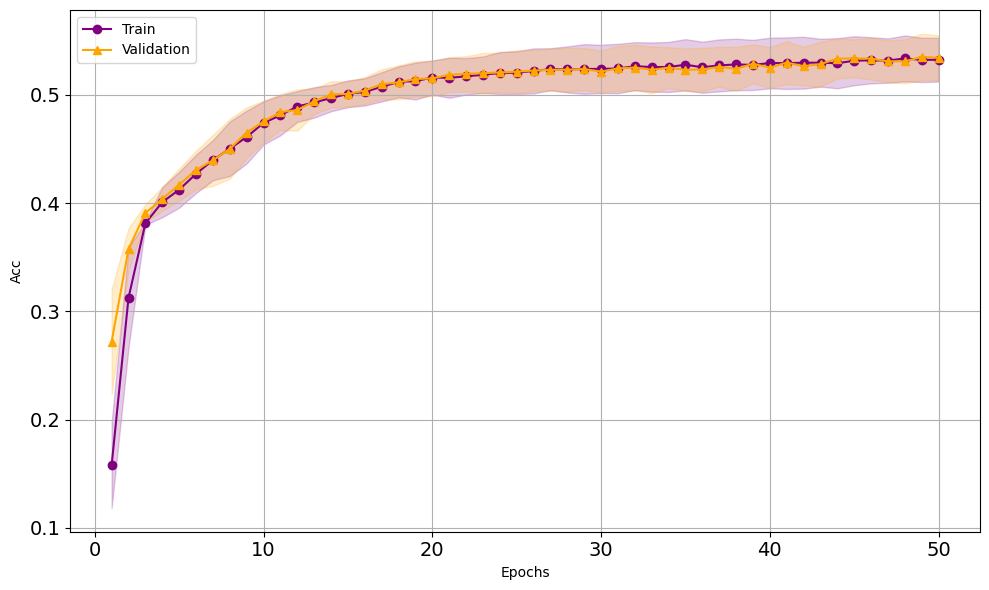

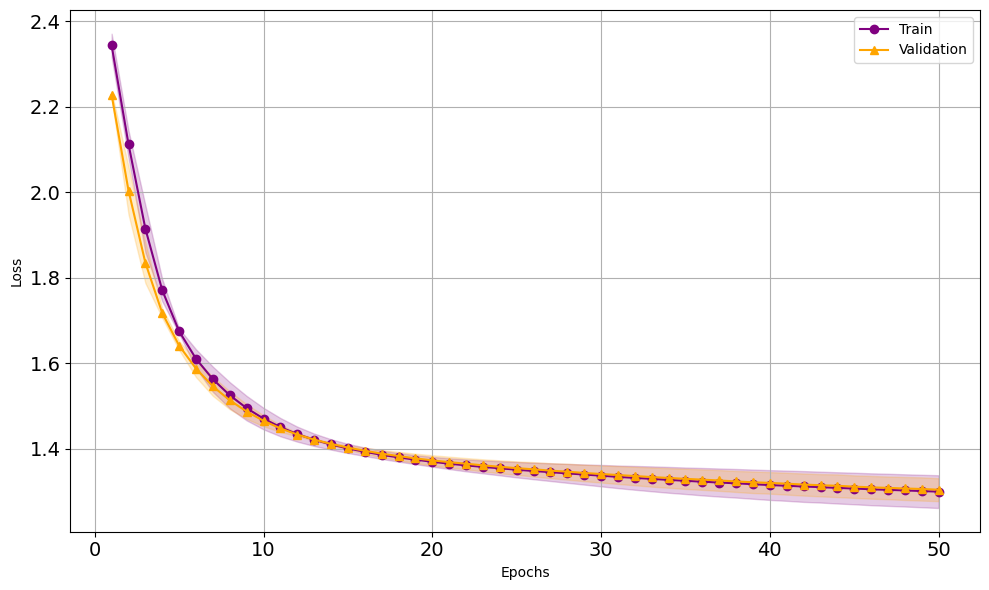

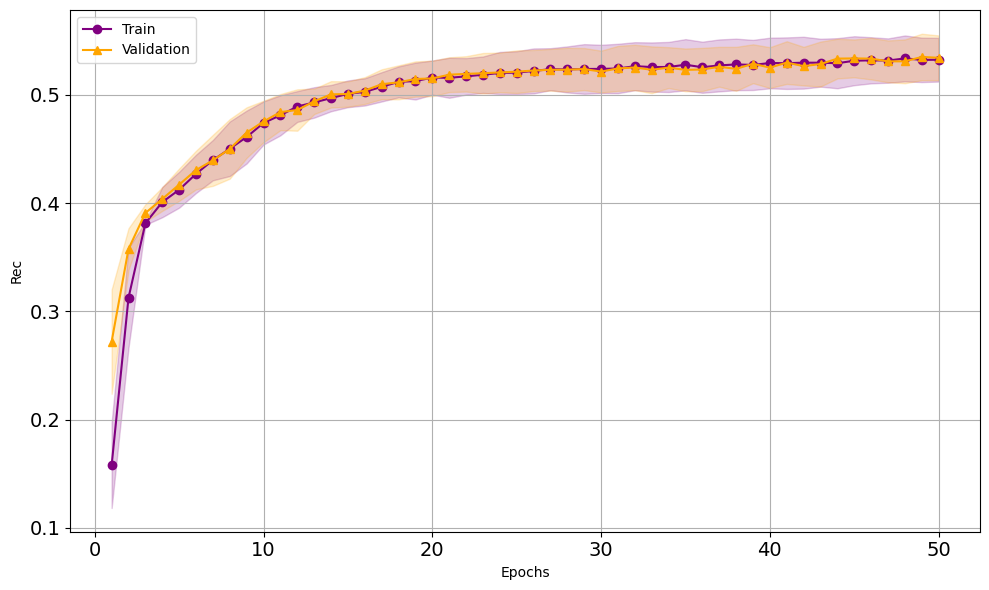

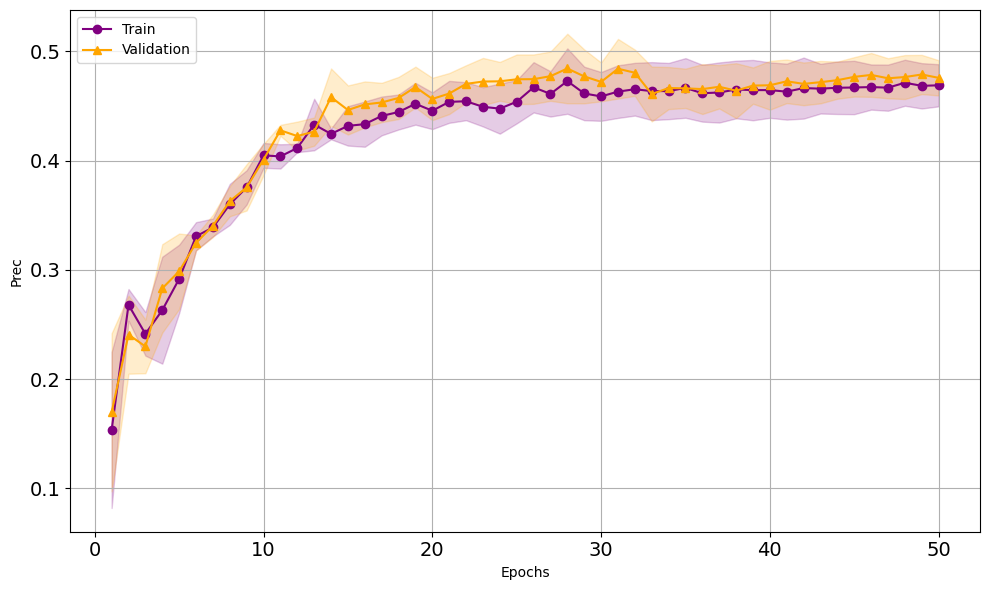

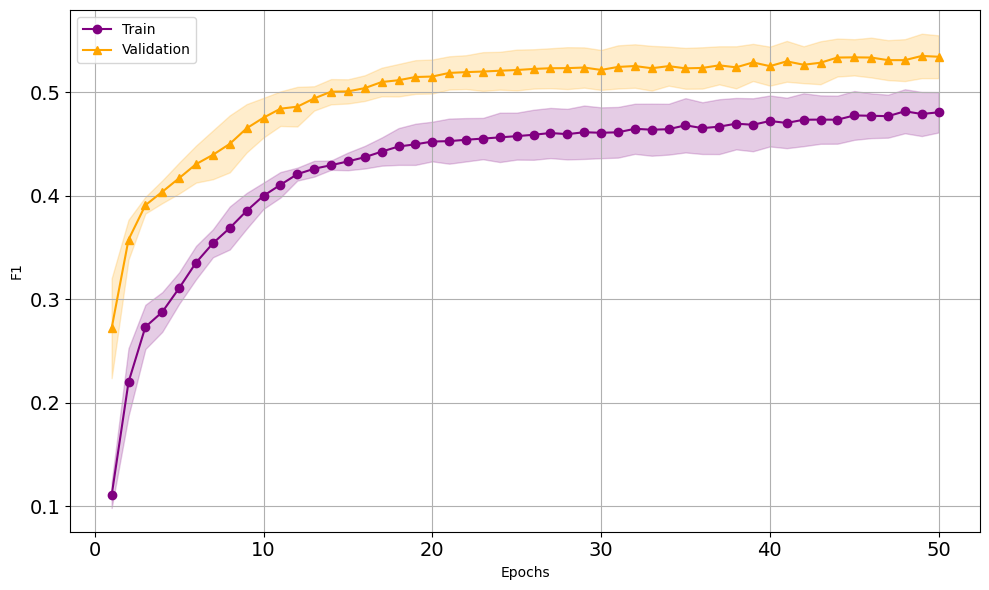

In [56]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range, classical=True, save_name=f"mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [33]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 2 with val_f1 = 0.5492


In [34]:
test_classical_model = ClassicalModel(n_classes=11)
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
# test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

# test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_classical_model, test_loader, optimizer, criterion, device)
test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, classical_test_probs, classical_test_labels = evaluate_v2(test_classical_model, test_loader, optimizer, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 628.98it/s, loss=1.4886, ac


Test loss: 1.4886 | Test acc: 0.4760 | Test rec: 0.4760 | Test prec: 0.4341 | Test f1: 0.4760


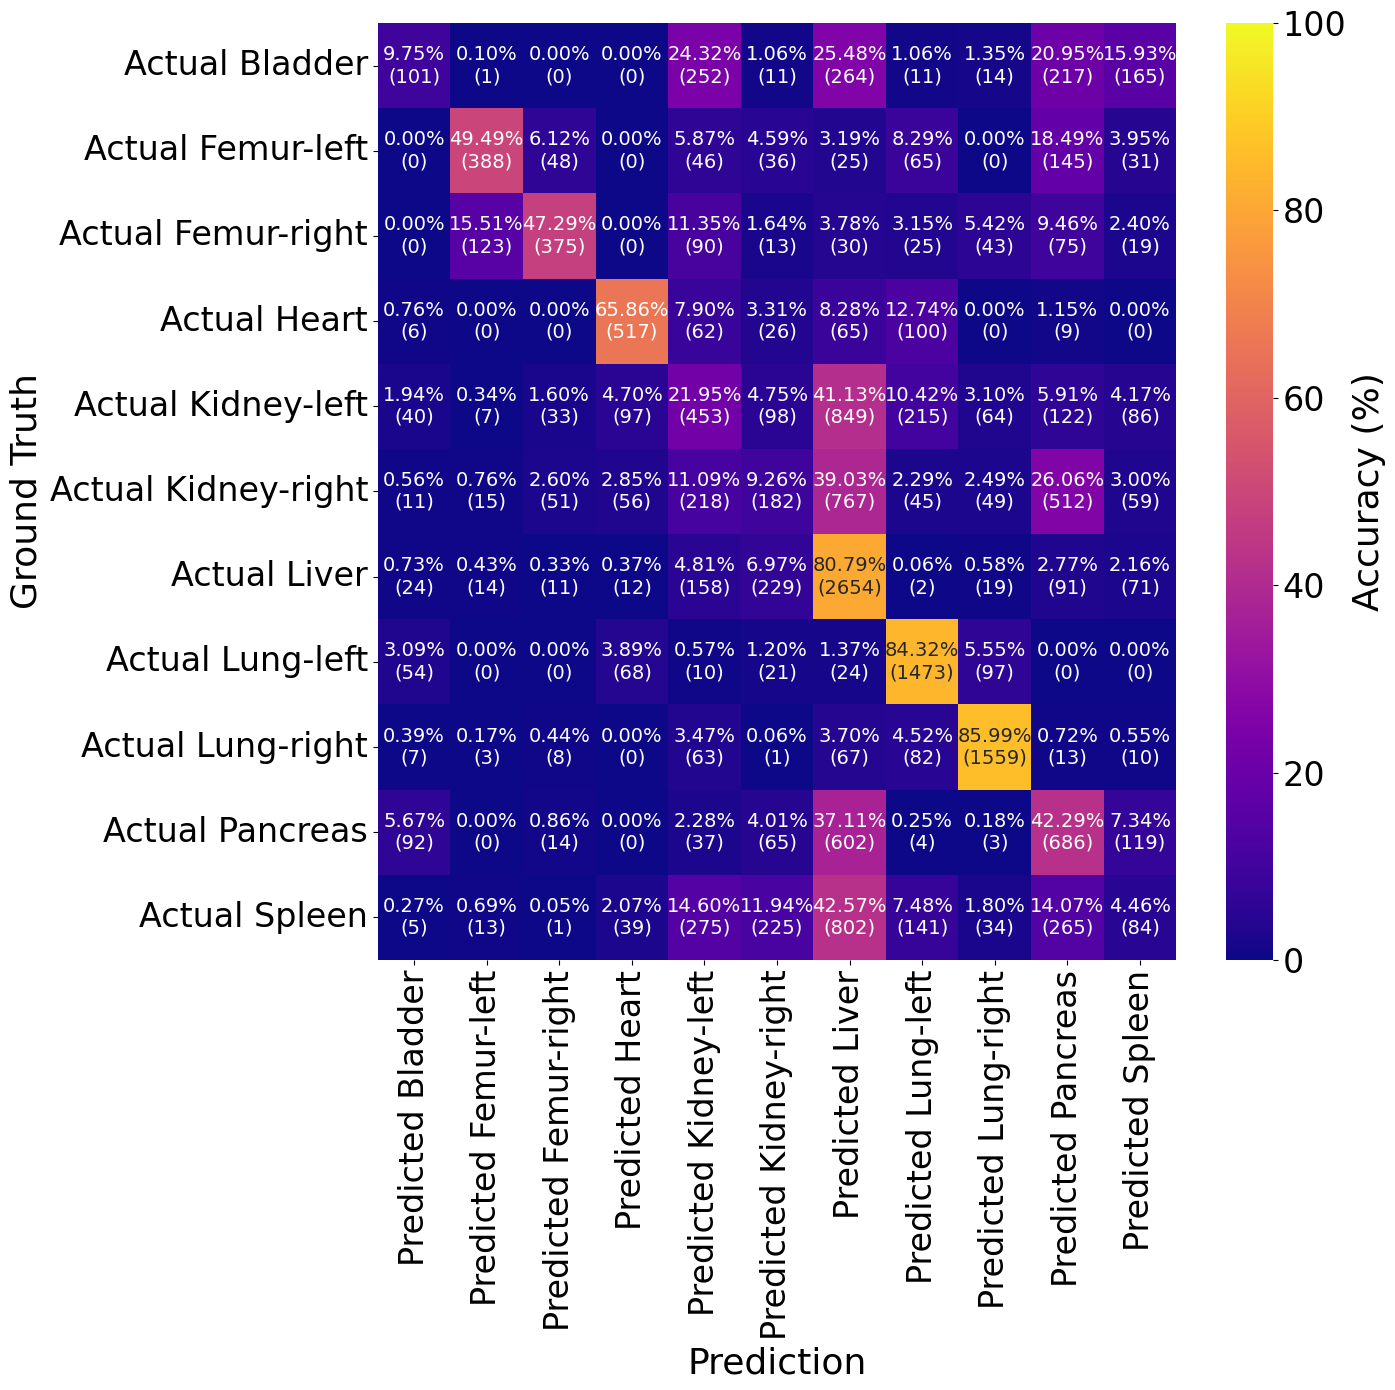

In [64]:
label_names = [
    "Bladder",
    "Femur-left",
    "Femur-right",
    "Heart",
    "Kidney-left",
    "Kidney-right",
    "Liver",
    "Lung-left",
    "Lung-right",
    "Pancreas",
    "Spleen",
]

plot_confusion_matrix(classical_test_labels, test_preds, label_names, model_name, binary=False)

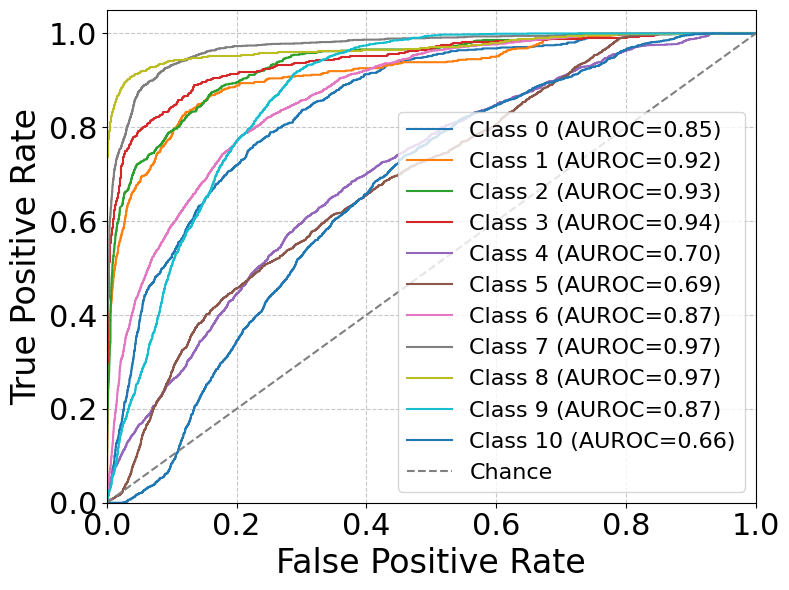

In [65]:
plot_auroc(classical_test_labels, classical_test_probs, model_name, binary=False)

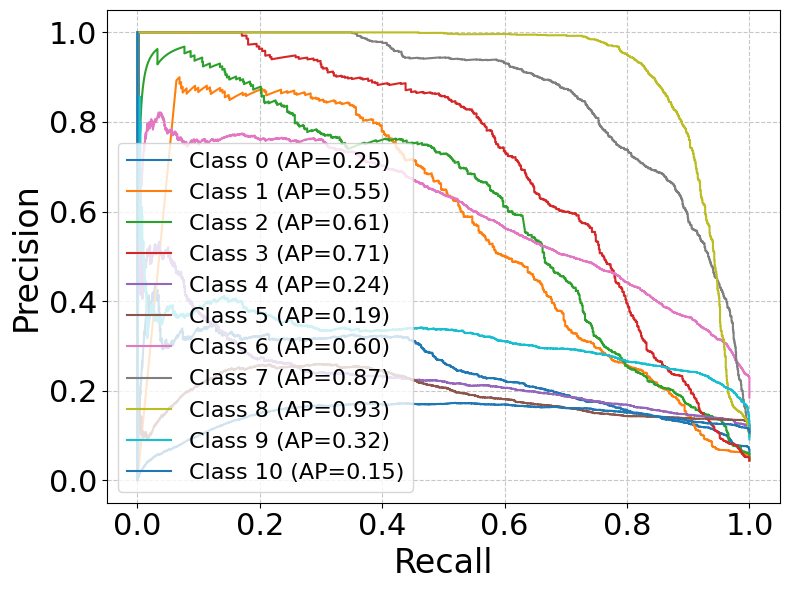

In [66]:
plot_prec(classical_test_labels, classical_test_probs, model_name, binary=False)

In [63]:
cam, outputs, predictions = gradcam_model(test_classical_model, x_test_tensor[0:16], quantum=False)
print(cam.shape)

torch.Size([16, 4])


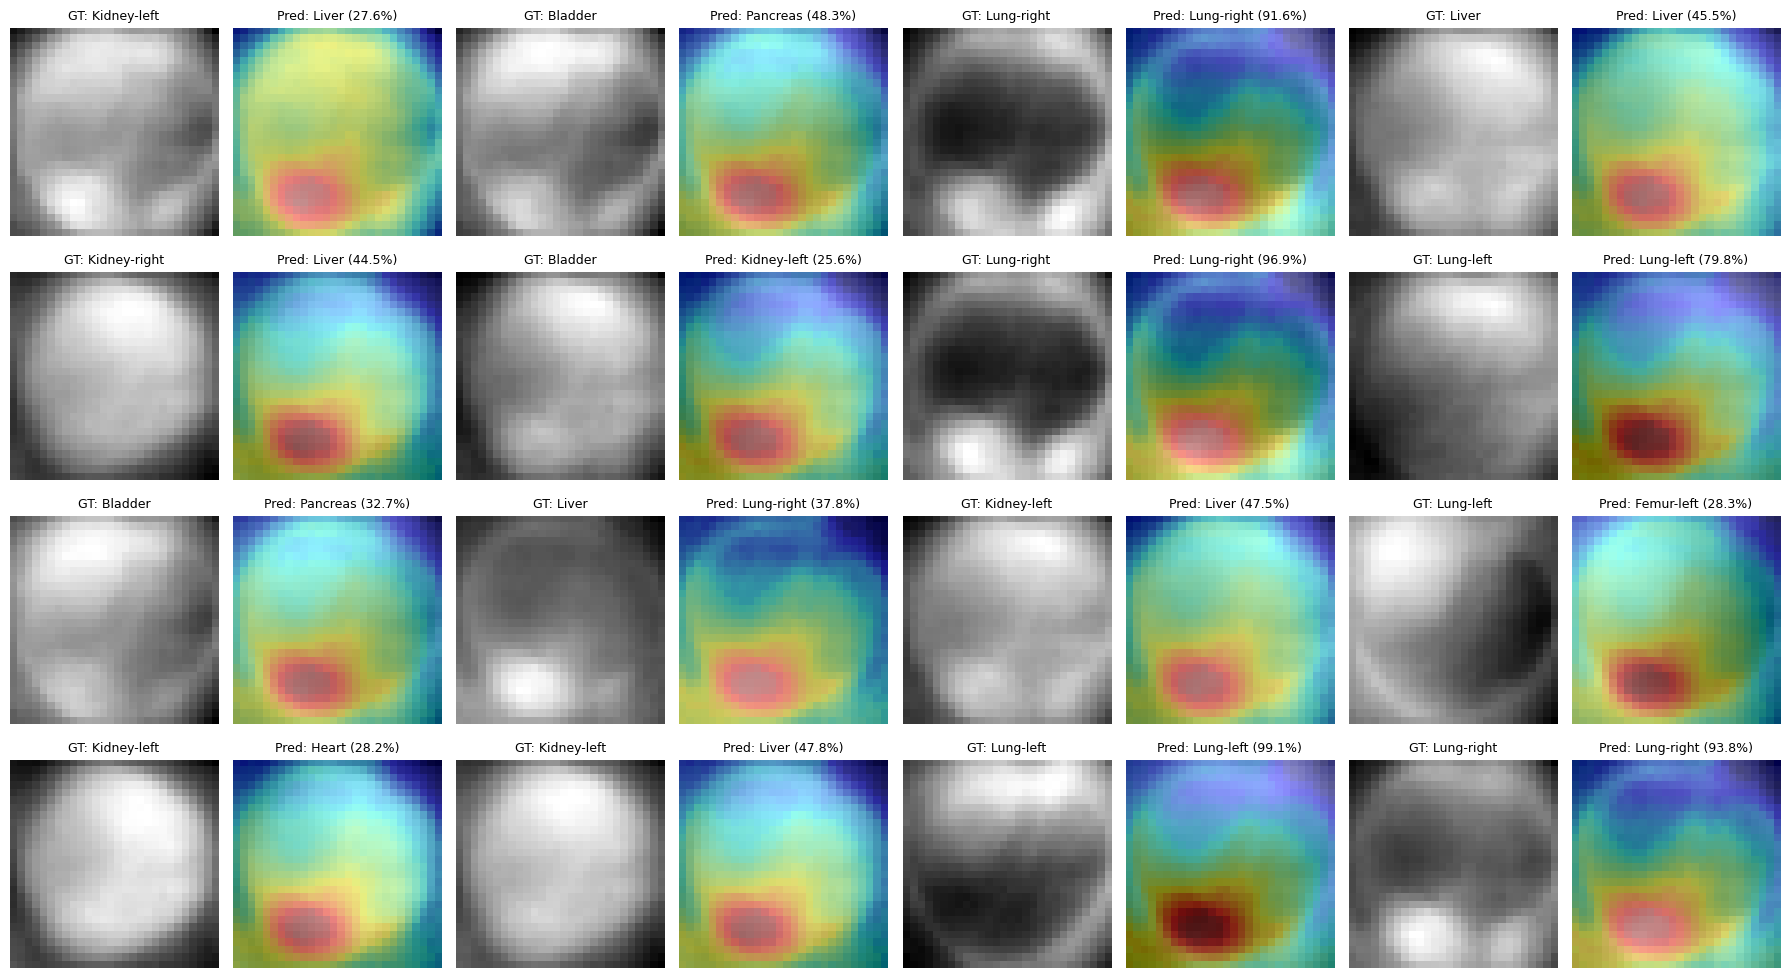

In [64]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## MODEL COMPARISON

In [67]:
import numpy as np
noise_std = np.arange(0.1, 1.05, 0.05)

cv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

classical_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dataset_name = "organ"

cv_noise_metrics = noise_robustness_validation(test_cv_model, test_loader, noise_std, cv_noise_metrics, "cv", optimizer, criterion, device)
dv_noise_metrics = noise_robustness_validation(test_dv_model, test_loader, noise_std, dv_noise_metrics, "dv", optimizer, criterion, device)
classic_noise_metrics = noise_robustness_validation(test_classical_model, test_loader, noise_std, classical_noise_metrics, "classical", optimizer, criterion, device)

[STD: 0.10] Clean mean: -0.0476, Noisy mean: -0.0477


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.18it/s, loss=1.6458, acc


[STD: 0.15] Clean mean: -0.0476, Noisy mean: -0.0476


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.21it/s, loss=1.6625, acc


[STD: 0.20] Clean mean: -0.0476, Noisy mean: -0.0479


Training | Epoch None: 100%|█| 556/556 [00:59<00:00,  9.27it/s, loss=1.6845, acc


[STD: 0.25] Clean mean: -0.0476, Noisy mean: -0.0481


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.12it/s, loss=1.7028, acc


[STD: 0.30] Clean mean: -0.0476, Noisy mean: -0.0482


Training | Epoch None: 100%|█| 556/556 [00:59<00:00,  9.28it/s, loss=1.7450, acc


[STD: 0.35] Clean mean: -0.0476, Noisy mean: -0.0463


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.17it/s, loss=1.7870, acc


[STD: 0.40] Clean mean: -0.0476, Noisy mean: -0.0481


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.14it/s, loss=1.8228, acc


[STD: 0.45] Clean mean: -0.0476, Noisy mean: -0.0458


Training | Epoch None: 100%|█| 556/556 [01:01<00:00,  9.11it/s, loss=1.8873, acc


[STD: 0.50] Clean mean: -0.0476, Noisy mean: -0.0478


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.12it/s, loss=1.9435, acc


[STD: 0.55] Clean mean: -0.0476, Noisy mean: -0.0491


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.19it/s, loss=2.0267, acc


[STD: 0.60] Clean mean: -0.0476, Noisy mean: -0.0478


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.15it/s, loss=2.0909, acc


[STD: 0.65] Clean mean: -0.0476, Noisy mean: -0.0505


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.14it/s, loss=2.1660, acc


[STD: 0.70] Clean mean: -0.0476, Noisy mean: -0.0449


Training | Epoch None: 100%|█| 556/556 [01:01<00:00,  9.10it/s, loss=2.2685, acc


[STD: 0.75] Clean mean: -0.0476, Noisy mean: -0.0509


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.23it/s, loss=2.3627, acc


[STD: 0.80] Clean mean: -0.0476, Noisy mean: -0.0503


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.22it/s, loss=2.4970, acc


[STD: 0.85] Clean mean: -0.0476, Noisy mean: -0.0487


Training | Epoch None: 100%|█| 556/556 [01:01<00:00,  9.10it/s, loss=2.5858, acc


[STD: 0.90] Clean mean: -0.0476, Noisy mean: -0.0472


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.14it/s, loss=2.6921, acc


[STD: 0.95] Clean mean: -0.0476, Noisy mean: -0.0481


Training | Epoch None: 100%|█| 556/556 [01:01<00:00,  9.11it/s, loss=2.8005, acc


[STD: 1.00] Clean mean: -0.0476, Noisy mean: -0.0499


Training | Epoch None: 100%|█| 556/556 [01:00<00:00,  9.12it/s, loss=2.9544, acc


[STD: 0.10] Clean mean: -0.0476, Noisy mean: -0.0480


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.61it/s, loss=1.7331, acc


[STD: 0.15] Clean mean: -0.0476, Noisy mean: -0.0481


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.61it/s, loss=1.7485, acc


[STD: 0.20] Clean mean: -0.0476, Noisy mean: -0.0489


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.60it/s, loss=1.7678, acc


[STD: 0.25] Clean mean: -0.0476, Noisy mean: -0.0474


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.60it/s, loss=1.7896, acc


[STD: 0.30] Clean mean: -0.0476, Noisy mean: -0.0464


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.62it/s, loss=1.8303, acc


[STD: 0.35] Clean mean: -0.0476, Noisy mean: -0.0470


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.60it/s, loss=1.8770, acc


[STD: 0.40] Clean mean: -0.0476, Noisy mean: -0.0474


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.60it/s, loss=1.9188, acc


[STD: 0.45] Clean mean: -0.0476, Noisy mean: -0.0473


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.61it/s, loss=1.9658, acc


[STD: 0.50] Clean mean: -0.0476, Noisy mean: -0.0460


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.60it/s, loss=2.0322, acc


[STD: 0.55] Clean mean: -0.0476, Noisy mean: -0.0486


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.62it/s, loss=2.0919, acc


[STD: 0.60] Clean mean: -0.0476, Noisy mean: -0.0489


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.62it/s, loss=2.1831, acc


[STD: 0.65] Clean mean: -0.0476, Noisy mean: -0.0447


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.61it/s, loss=2.2437, acc


[STD: 0.70] Clean mean: -0.0476, Noisy mean: -0.0465


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.62it/s, loss=2.3159, acc


[STD: 0.75] Clean mean: -0.0476, Noisy mean: -0.0528


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.61it/s, loss=2.3866, acc


[STD: 0.80] Clean mean: -0.0476, Noisy mean: -0.0512


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.60it/s, loss=2.4890, acc


[STD: 0.85] Clean mean: -0.0476, Noisy mean: -0.0477


Training | Epoch None: 100%|█| 556/556 [03:31<00:00,  2.63it/s, loss=2.5713, acc


[STD: 0.90] Clean mean: -0.0476, Noisy mean: -0.0487


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.62it/s, loss=2.6646, acc


[STD: 0.95] Clean mean: -0.0476, Noisy mean: -0.0532


Training | Epoch None: 100%|█| 556/556 [03:32<00:00,  2.61it/s, loss=2.7677, acc


[STD: 1.00] Clean mean: -0.0476, Noisy mean: -0.0431


Training | Epoch None: 100%|█| 556/556 [03:33<00:00,  2.61it/s, loss=2.8193, acc


[STD: 0.10] Clean mean: -0.0476, Noisy mean: -0.0484


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 642.59it/s, loss=1.5109, ac


[STD: 0.15] Clean mean: -0.0476, Noisy mean: -0.0484


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 678.98it/s, loss=1.5296, ac


[STD: 0.20] Clean mean: -0.0476, Noisy mean: -0.0491


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 653.30it/s, loss=1.5654, ac


[STD: 0.25] Clean mean: -0.0476, Noisy mean: -0.0482


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 657.74it/s, loss=1.6048, ac


[STD: 0.30] Clean mean: -0.0476, Noisy mean: -0.0471


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 652.26it/s, loss=1.6487, ac


[STD: 0.35] Clean mean: -0.0476, Noisy mean: -0.0477


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 601.15it/s, loss=1.7016, ac


[STD: 0.40] Clean mean: -0.0476, Noisy mean: -0.0468


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 696.72it/s, loss=1.7770, ac


[STD: 0.45] Clean mean: -0.0476, Noisy mean: -0.0492


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 641.54it/s, loss=1.8445, ac


[STD: 0.50] Clean mean: -0.0476, Noisy mean: -0.0467


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 696.36it/s, loss=1.9194, ac


[STD: 0.55] Clean mean: -0.0476, Noisy mean: -0.0478


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 686.46it/s, loss=1.9882, ac


[STD: 0.60] Clean mean: -0.0476, Noisy mean: -0.0470


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 648.07it/s, loss=2.0884, ac


[STD: 0.65] Clean mean: -0.0476, Noisy mean: -0.0515


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 694.40it/s, loss=2.2183, ac


[STD: 0.70] Clean mean: -0.0476, Noisy mean: -0.0493


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 714.89it/s, loss=2.3179, ac


[STD: 0.75] Clean mean: -0.0476, Noisy mean: -0.0479


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 674.77it/s, loss=2.4185, ac


[STD: 0.80] Clean mean: -0.0476, Noisy mean: -0.0514


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 667.24it/s, loss=2.5306, ac


[STD: 0.85] Clean mean: -0.0476, Noisy mean: -0.0567


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 686.79it/s, loss=2.6360, ac


[STD: 0.90] Clean mean: -0.0476, Noisy mean: -0.0498


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 702.52it/s, loss=2.7636, ac


[STD: 0.95] Clean mean: -0.0476, Noisy mean: -0.0393


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 677.66it/s, loss=2.9116, ac


[STD: 1.00] Clean mean: -0.0476, Noisy mean: -0.0497


Training | Epoch None: 100%|█| 556/556 [00:00<00:00, 623.43it/s, loss=3.0576, ac


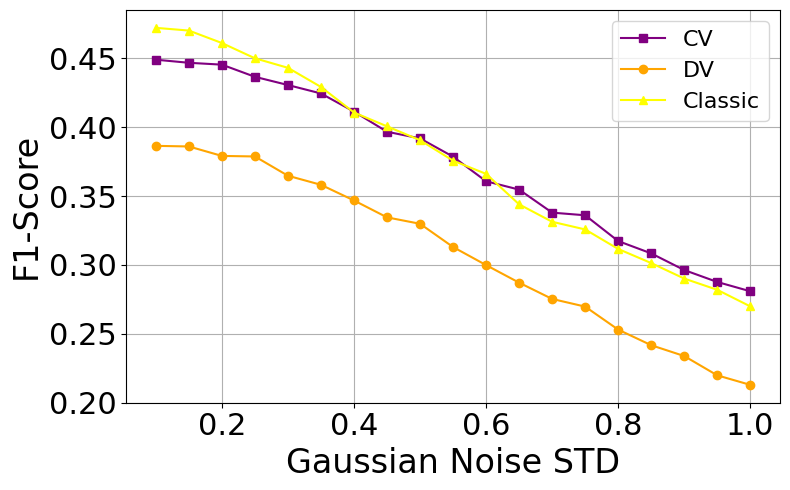

In [68]:
plot_noise_comparison(cv_noise_metrics["f1"], dv_noise_metrics["f1"], classic_noise_metrics["f1"], noise_std, "F1-Score", dataset_name)

## RELIABILITY ASSESSMENT

In [35]:
import numpy as np
cv_test_probs_np = np.array(cv_test_probs)
dv_test_probs_np = np.array(dv_test_probs)
classical_test_probs_np = np.array(classical_test_probs)

In [36]:
def brier_score(y_true, y_prob):
    #binary
    if y_prob.ndim == 1 or y_prob.shape[1] == 1:
        return np.mean((y_prob - y_true)**2)

    #multiclass
    n_classes = y_prob.shape[1]
    y_true_onehot = np.eye(n_classes)[y_true]
    return np.mean(np.sum((y_prob - y_true_onehot)**2, axis=1))

def compute_ece(y_true, y_prob, n_bins=10):
    #ensure numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if y_prob.ndim > 1 and y_prob.shape[1] > 1:
        confidences = np.max(y_prob, axis=1)
        preds = np.argmax(y_prob, axis=1)

    else:
        confidences = y_prob
        preds = (y_prob >= 0.5).astype(int)

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1

    ece = 0.0
    total = len(y_true)

    for b in range(n_bins):
        idx = np.where(bin_ids == b)[0]
        if len(idx) == 0:
            continue

        acc = np.mean(y_true[idx] == preds[idx])
        conf = np.mean(confidences[idx])
        ece += (len(idx) / total) * abs(acc - conf)

    return ece

In [37]:
def reliability_diagram_multi(models_data, dataset_name, n_bins=10, save_name=None):

    """
    models_data = {
    "classical": (y_true, y_prob),
    "dv": (y_true, y_prob),
    "cv": (y_true, y_prob)
    }
    """
    
    plt.figure(figsize=(8,6))
    plt.plot([0,1], [0,1], '--', color='gray', label="Perfect Calibration")

    for name, (y_true, y_prob) in models_data.items():
        #ensure numpy arrays
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)
        
        if y_prob.ndim > 1 and y_prob.shape[1] > 1:
            conf = np.max(y_prob, axis=1)
            pred = np.argmax(y_prob, axis=1)
        else:
            conf = y_prob
            pred = (y_prob >= 0.5).astype(int)

        bins = np.linspace(0, 1, n_bins + 1)
        bin_ids = np.digitize(conf, bins) - 1

        accs, confs = [], []
        for b in range(n_bins):
            idx = np.where(bin_ids == b)[0]
            if len(idx) == 0:
                continue
            accs.append((y_true[idx] == pred[idx]).mean())
            confs.append(conf[idx].mean())

        plt.plot(confs, accs, marker="o", label=name)

    plt.xlabel("Mean confidence", fontsize=26)
    plt.ylabel("Accuracy", fontsize=26)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)

    if save_name:
        # plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/{save_name}_{dataset_name}", dpi=300)
        plt.savefig(f"/home/dalopezm/gaussian-qnns/results/{save_name}_{dataset_name}", dpi=300)

    plt.show()

CV brier: 0.6770617158709338
DV brier: 0.7327198101656671
classical brier: 0.6426886752408585
CV ece: 0.03223442466880731
DV ece: 0.049893401071156016
classical ece: 0.02932608221134865


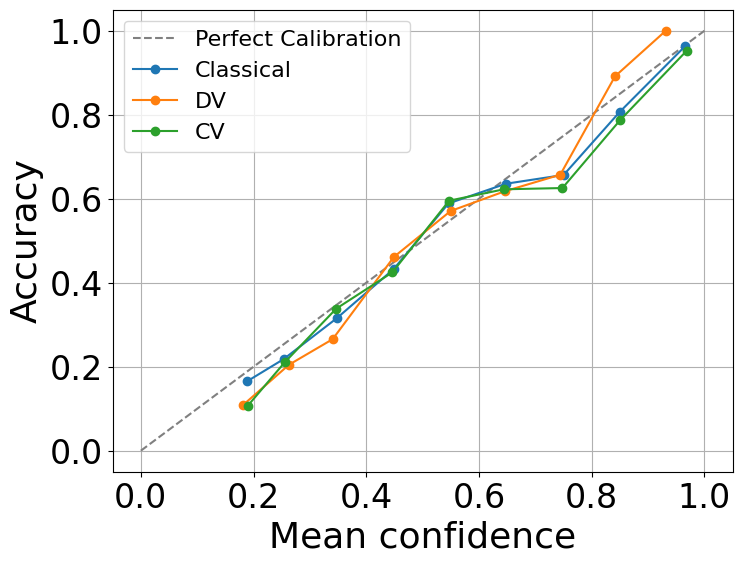

In [38]:
# brier_score(y_true, y_prob)
# ece(y_true, y_prob)
# reliability(y_true, y_prob)

models_data = {
    "Classical": (classical_test_labels, classical_test_probs_np),
    "DV": (dv_test_labels, dv_test_probs_np),
    "CV": (cv_test_labels, cv_test_probs_np)
}


#brier score for ORGANA
cv_brier = brier_score(cv_test_labels, cv_test_probs_np)
dv_brier = brier_score(dv_test_labels, dv_test_probs_np)
classical_brier = brier_score(classical_test_labels, classical_test_probs_np)

#ECE value for ORGANA
cv_ece = compute_ece(cv_test_labels, cv_test_probs_np)
dv_ece = compute_ece(dv_test_labels, dv_test_probs_np)
classical_ece = compute_ece(classical_test_labels, classical_test_probs_np)

print(f"CV brier: {cv_brier}")
print(f"DV brier: {dv_brier}")
print(f"classical brier: {classical_brier}")

print(f"CV ece: {cv_ece}")
print(f"DV ece: {dv_ece}")
print(f"classical ece: {classical_ece}")

#Multiplot assessment for ORGANA
reliability_diagram_multi(models_data, "organ", save_name="reliability")